<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Part 2 ‚Äî Subreddit Posts Classification

## Background

Twitch is an American interactive livestreaming service for content spanning gaming, entertainment, sports, music, and more ([*source*](https://www.twitch.tv/p/en/about/)).

Similar to many other online social platforms, we are always looking for new ways to better engage our users, expands our products and service offerings, thereby increasing customer stickiness through greater user experience and improving both top and bottom lines.

_**Why Gaming?**_<br>
- **Video Gaming Industry**: ~$178.73 Billion in 2021 (increase of 14.4% from 2020) ([*source*](https://www.wepc.com/news/video-game-statistics/))

- **Global eSports market**: ~$1.08 Billion in 2021 (increase of ~50% from 2020) ([*source*](https://www.statista.com/statistics/490522/global-esports-market-revenue/))

- **eSports industry's global market revenue**: Forecasted to grow to as much as $1.62 Billion in 2024. 

- China alone accounts for almost 1/5 of this market. 

In recent months, we started a pilot program with a subset of our most active users by availing them to a new beta forum that has sparked many discussions amongst our gaming users.

This has resulted in hightened traffic with frequent posts and comments updates daily. Our business development and marketing counterparts also realised these gaming users are predominantly focusing on 2 games, namely Dota 2 ([*source*](https://www.dota2.com/home)) and League of Legends (LoL) ([*source*](https://leagueoflegends.com)). 

Our business development and marketing colleagues see great potential in tapping on this group of active gamers and the associated data. However, since there is merely 1 single beta gaming forum thread, users have to sieve through multiple posts to find topics that interest or are relevant to them, resulting in potential poor user experience. Additionally, it would be more effective and efficient to target each game's user base separately by designing sales and marketing campaigns that better meet the corresponding user base's needs.

## Problem Statement

- Our business development and marketing colleagues have requested for us, the Data Science team, to design an **AI model** that **correctly classifies posts** in the 1 single beta gaming forum thread into 2 separate threads, 1 for Dota 2 and another for League of Legends (LoL), with an **accuracy of at least 85%** and **Top 10 Predictors for each subreddit** thereby improving user experience and increasing ease of designing more targeted sales and marketing campaigns that better meet the corresponding user base's needs.

**Datasets scraped:** _(Refer to **Part 1 ‚Äî Subreddit Posts Extraction** for Data Scraping code)_
 - dota2_raw.csv: Dota 2 dataset
 - lol_raw.csv: League of Legends (LoL) dataset
<br>

**Brief Description of Datasets selected:** 
- The 2 datasets above, each comprising 4,000 records, were scrapped using the pushshift API ([*source*](https://github.com/pushshift/api)) from subreddits: 
  - **r/DotA2** ([*source*](https://www.reddit.com/r/DotA2/)); and 
  - **r/leagueoflegends** ([*source*](https://www.reddit.com/r/leagueoflegends/))

---

## Data Cleaning, Preprocessing & Visualisation

We will perform the following steps for data cleaning, preprocessing and visualisation:
1. Import relevant libraries
2. Data Cleaning (Part 1):
 - Check for Duplicates
 - Delete Rows for Removed Posts
3. Establish Baseline Score for Accuracy
4. Data Cleaning (Part 2) & Preprocessing:
 - Replace null cells with ''
 - Replace URLs in text strings with ''
 - Replace Punctuations in text strings with ' '
 - Tokenize Data
 - Remove Tokenized Words with customised Stopwords List 
 - Data Lemmatization
 - Data Stemming
 - Sentence Forming with Processed Tokens
5. Visualising Most Frequent Words
 - Count Vectorization - 1 & 2 ngram Count Vectorizer
 - TF-IDF Vectorization - 1 & 2 ngram Count Vectorizer

## Import Libraries, Datasets and Data Cleaning

In [1]:
# Import relevant libraries
import datetime
import time
import numpy as np
import pandas as pd
import nltk
import re
import string
from collections import Counter
from itertools import chain
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statistics
from matplotlib.gridspec import GridSpec
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, fbeta_score, make_scorer, f1_score, roc_auc_score, plot_roc_curve, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

# Instantiate WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
# Instantiate PorterStemmer
ps = nltk.PorterStemmer()

string.punctuation    # string.punctuation comprises of a list of all punctuations

pd.set_option('display.max_colwidth', 100)

# Initialise default library settings
#pd.set_option("display.max_columns", None)           #Set pandas to display unlimited columns
#pd.set_option("display.max_rows", None)              #Set pandas to display unlimited rows
pd.set_option("display.precision", 2)                # Use 2 decimal places in output display
pd.set_option("display.expand_frame_repr", False)    # Don't wrap repr (DataFrame) across additional lines

# Switch to seaborn defaults
sns.set_theme()
sns.set(font_scale=1.4)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# Function to compare all rows in dataset to check for duplicated rows
def duplicate(df):
    
    if len(df[df.duplicated()]) == 0:
        return "This dataset has no duplicated rows."
    else:
        print(f'Duplicated row(s):\n {df[df.duplicated()]}')  # List duplicated row(s) in dataset, if any
    
    return




# Function to check each column of selected dataset for nulls &
# Display summary table of all columns with at least 1 null, number of nulls & % Total number of rows  
def column_nulls(df):
    
    null = df.isnull().sum()
    null_percent = 100 * df.isnull().sum() / len(df)
    null_table = pd.concat([null, null_percent], axis=1)
    null_table_ren_columns = null_table.rename(columns = {0 : 'Number of Nulls', 1 : '% of Total'})
    null_table_ren_columns = null_table_ren_columns[
        null_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total', ascending=False).round(2)
    
    print ("This dataframe has " + str(df.shape[1]) + " columns.\n"
           "There are " + str(null_table_ren_columns.shape[0]) + " columns with null values.")
    
    return null_table_ren_columns




# Function to display summary table of each unique column value & % Total number of rows in selected dataset   
def column_values(df, col):
    
    value = df[col].value_counts(dropna=False)
    value_percent = round(100 * df[col].value_counts(dropna=False) / len(df[col]), 2)
    value_table = pd.concat([value, value_percent], axis=1)
    value_table.columns = ['Count', '% of Total']
    
    return value_table




# Function to remove punctuations in text strings   
def del_punctuation(text):
    # store character only if it is not a punctuation
    text_nopunct = ''.join([char for char in text if char not in string.punctuation])
    return text_nopunct




# Function to tokenize text strings   
def tokenize(text):
    # Matches any character that is neither alphanumeric nor underscore
    # Add a + just in case there are 2 or more spaces between certain words
    tokens = re.split('\W+', text)
    return tokens




# Function to remove stop words from tokens 
def del_stopwords(tokenized_list, stopwords_list = nltk.corpus.stopwords.words('english')):
    # Store in text only if word is not found in stopword i.e. it is not a stopword
    text = [word for word in tokenized_list if word not in stopwords_list]
    return text




# Function to lemmatize tokens   
def lemmatize(tokenized_list):
    # Returns list of all lemmatized words for their corresponding words in tokenized_list
    text = [lemmatizer.lemmatize(word) for word in tokenized_list]
    return text




# Function to stem tokens   
def stemming(tokenized_list):
    # Returns list of all stemmed words for their corresponding words in tokenized_list
    text = [ps.stem(word) for word in tokenized_list]
    return text

In [3]:
# Import the 2 datasets
dota2 = pd.read_csv('../datasets/dota2_raw.csv')    # Import dota2 dataset
lol = pd.read_csv('../datasets/lol_raw.csv')        # Import lol dataset

dota2_lol = dota2.append(lol).reset_index(drop=True)
dota2_lol.shape

(7999, 87)

### Data Cleaning: Check for Duplicates

In [4]:
# Compare all rows in the dota2_lol dataset to check for duplicates
duplicate(dota2_lol)
#dota2_lol.to_csv('../datasets/dota2_lol.csv', index = False)

'This dataset has no duplicated rows.'

### Data Cleaning: Delete Rows for Removed Posts 

In [5]:
# Status in 'removed_by_category' column:
# 'automod_filtered' : Post filtered by AutoModerator
# 'deleted'          : Post deleted by post's author
# 'moderator'        : Post removed by moderator
# 'reddit'           : Post removed by reddit's spam filters
# 'null'             : Posts live & visible

# As at 21May2022 0936HRS:
#    DotA2: ~1,068,958 members
#    leagueoflegends: ~5,842,160 members (i.e. ~5.465 X larger than DotA2)

# https://www.reddit.com/r/redditdev/comments/kypjmk/check_if_submission_has_been_removed_by_a_mod/
# https://boostupvotes.com/2021/04/19/how-to-check-if-your-reddit-post-is-live/

dota2_lol.groupby(['subreddit', 'removed_by_category'])["removed_by_category"].count()
#dota2_lol.groupby(['subreddit', 'removed_by_category']).count().reset_index()
#print(dota2_lol.groupby(['subreddit', 'removed_by_category'], as_index=False)['author','allow_live_comments','banned_by'].agg(lambda x: list(x)))

subreddit        removed_by_category
DotA2            automod_filtered        137
                 deleted                  17
                 moderator               145
                 reddit                  287
leagueoflegends  automod_filtered        212
                 deleted                  29
                 moderator              1253
                 reddit                  101
Name: removed_by_category, dtype: int64

- Since both subreddits have massive memberships (DotA2: ~1.07million, leagueoflegends: ~5.84million as at 21May2022 0936HRS), these are natural targets by spammers.
- Excluding posts deleted by their authors, 
 - leagueoflegends attracts disproportionately (~2.75 X) more spam in total than DotA2 (i.e. 1566 vs 569).
 - Moderators did most work to remove leagueoflegends' total spams: 80% (1253/1566) for LOL vs 25% (145/569) for DotA2.
 - However, this is partly due to Reddit's spam filters removing 50% (287/569) of DotA2's total spams vs 6% (101/1566) for LOL
 - This implies potentially more human than bot spammers involved and/or more sophisticated spamming tactics deployed in leagueoflegends' spams, as indicated by the dramatically lower effectiveness of Reddit's spam filters.

In [6]:
# Remove posts banned by moderator/reddit & deleted posts based on status in 'removed_by_category' column:
dota2_lol = dota2_lol[dota2_lol['removed_by_category'].isna()].reset_index(drop=True)
dota2_lol.shape

(5818, 87)

In [7]:
#dota2_lol.loc[(dota2_lol['subreddit'] == 'DotA2')]
dota2_posts = len(dota2_lol.loc[(dota2_lol['subreddit'] == 'DotA2')])
lol_posts = len(dota2_lol.loc[(dota2_lol['subreddit'] == 'leagueoflegends')])

print(f'There are {dota2_posts} Dota2 posts, comprising {round(100 * dota2_posts / (dota2_posts + lol_posts), 2)}% of total posts.')
print(f'There are {lol_posts} League of Legends posts, comprising {round(100 * lol_posts / (dota2_posts + lol_posts), 2)}% of total posts.')

There are 3414 Dota2 posts, comprising 58.68% of total posts.
There are 2404 League of Legends posts, comprising 41.32% of total posts.


> There is no formal definition of when a dataset is imbalanced. The general rule of thumb is ratio **greater than 60:40** can be regarded as **imbalanced** (Google, 2020). ([*source*](https://rpubs.com/DeclanStockdale/799284))
>
> Since the ratio 3414:2404 is less than 60:40, this dataset is marginally balanced. Therefore, **Synthetic Minority Oversampling Technique (SMOTE)** is not applied in this instance.
>
> However, if the accuracy of the models are poor, SMOTE could be applied to potentially improve model accuracy. 

### Baseline Score for Accuracy: 0.5868

Since there are **3414** Dota2 posts and **2404** League of Legends posts, corresponding to **58.68%** and **41.32%** of total posts respectively, if we were to adopt a highly simplistic approach of predicting every post to be a Dota2 post, we would have scored **0.5868** (i.e. **58.68%**) in terms of **Accuracy**.

Thus, we could use **0.5868** as the **baseline score** for **Accuracy** that our best model should beat. 

### Data Cleaning: Replace null cells with ''

In [8]:
# Check dota2_lol dataset for nulls & display summary table in descending order (for non-zero nulls columns only)
column_nulls(dota2_lol)

This dataframe has 87 columns.
There are 38 columns with null values.


Number of Nulls  % of Total
category                                  5818      100.00
removed_by_category                       5818      100.00
call_to_action                            5818      100.00
banned_by                                 5818      100.00
link_flair_background_color               5818      100.00
author_cakeday                            5801       99.71
crosspost_parent_list                     5787       99.47
crosspost_parent                          5787       99.47
poll_data                                 5763       99.05
discussion_type                           5757       98.95
gallery_data                              5735       98.57
is_gallery                                5734       98.56
suggested_sort                            5723       98.37
author_flair_background_color             5550       95.39
media_metadata                            5368       92.27
secure_media_embed                        5305       91.18
media_embed                               5305       91.18
media                                     5301       91.11
secure_media                              5301       91.11
author_flair_css_class                    4447       76.44
author_flair_template_id                  4112       70.68
author_flair_text                         4049       69.59
author_flair_text_color                   3894       66.93
url_overridden_by_dest                    3695       63.51
preview                                   3475       59.73
post_hint                                 3475       59.73
thumbnail_width                           3399       58.42
thumbnail_height                          3399       58.42
link_flair_template_id                    2442       41.97
link_flair_text                           2405       41.34
link_flair_css_class                      2385       40.99
selftext                                  2123       36.49
link_flair_text_color                        4        0.07
author_premium                               3        0.05
author_patreon_flair                         3        0.05
author_fullname                              3        0.05
author_flair_type                            3        0.05
author_flair_richtext                        3        0.05

In [9]:
# Replace null cells in 'selftext' column with ''
dota2_lol['selftext'] = dota2_lol['selftext'].fillna('')

# Create new 'title_selftext' column from contents in existing 'title' and 'selftext' columns separated comma
dota2_lol['title_selftext'] = dota2_lol['title'].astype(str) + ', ' + dota2_lol['selftext'].astype(str)

In [10]:
# Create new dataframe for subreddit posts classification
dota2_lol_c = dota2_lol[['subreddit', 'title_selftext']].copy(deep=True)

### Data Cleaning: Replace URLs in text strings with ''

#### Potentially Better Regular Expression for identifying URLs in text (but somehow hangs the Python code):

John Gruber's "Improved Liberal, Accurate Regex Pattern for Matching URLs"
https://gist.github.com/gruber/249502
Regex patterns to match any URLs, including "mailto:foo@example.com", "x-whatever://foo", etc.

Single-line version of pattern:

url_regex = r'''(?i)\b((?:[a-z][\w-]+:(?:/{1,3}|[a-z0-9%])|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?¬´¬ª‚Äú‚Äù‚Äò‚Äô]))'''

https://www.tutorialexample.com/best-practice-to-extract-and-remove-urls-from-python-string-python-tutorial/

---

#### Applied Regular Expression for identifying URLs in text:

url_regex = '(?:https?:\/\/(?:www\.)?|https:(?:\/\/)?)?\w+(?:[-.]\w+)+(?:\/[^\/\s]+)*'

- https://stackoverflow.com/questions/71035383/is-there-any-url-regex-validator-that-fits-this-criteria
- https://regex101.com/r/ibx3ED/2

Details:

- ^ - start of the string
- (?:https?:\/\/(?:www\.)?|https:(?:\/\/)?)? - an optional sequence of:
 - https?:\/\/(?:www\.)? - http or https, :// and then an optional www. substring
 - | - or
 - https:(?:\/\/)? - https: and then an optional // string
- \w+ - one or more word chars
- (?:[-.]\w+)+- one or more sequences of a . or - followed with one or more word chars
- (?:\/[^\/\s]+)* - an optional sequence of a / an then one or more chars other than / and whitespace
- $ - end of string.

In [11]:
# Sample 1 cell in 'title_selftext' column to verify URL text removal
dota2_lol_c[['title_selftext']].iloc[17]

title_selftext    Clean aegis snatch on Void Spirit, [https://clips.twitch.tv/BloodyTameArtichokeWow-XlQLcnDNhY0Tv...
Name: 17, dtype: object

In [12]:
# Sample 2 cell in 'title_selftext' column to verify URL text removal
dota2_lol_c[['title_selftext']].iloc[226]

#dota2_lol_c[dota2_lol_c['title_selftext'].str.contains('http', regex=False)]
#dota2_lol_c[dota2_lol_c['title_selftext'].str.contains('.com', regex=False)]

title_selftext    Sun Tzu - The Art Of War : A DOTA 2 Video Essay - (https://www.youtube.com/watch?v=nvYPwgm-Vhc), 
Name: 226, dtype: object

In [13]:
# Replace URLs in 'title_selftext' column with ''
url_regex = '(?:https?:\/\/(?:www\.)?|https:(?:\/\/)?)?\w+(?:[-.]\w+)+(?:\/[^\/\s]+)*'
dota2_lol_c['title_selftext'] = dota2_lol_c['title_selftext'].apply(lambda x: re.sub(url_regex, '', x))

In [14]:
# Verify only the URL text in Sample 1 cell in 'title_selftext' column is removed
dota2_lol_c[['title_selftext']].iloc[17]

title_selftext    Clean aegis snatch on Void Spirit, [//
Name: 17, dtype: object

In [15]:
# Verify only the URL text in Sample 2 cell in 'title_selftext' column is removed
dota2_lol_c[['title_selftext']].iloc[226]

title_selftext    Sun Tzu - The Art Of War : A DOTA 2 Video Essay - ( 
Name: 226, dtype: object

In [16]:
# Remove all leading and trailing spaces in 'title_selftext' column
dota2_lol_c['title_selftext'] = dota2_lol_c['title_selftext'].apply(lambda x: x.strip() if isinstance(x, str) else x)

### Data Cleaning: Replace Punctuations in text strings with ' '

In [17]:
dota2_lol_c['ts_clean'] = dota2_lol_c['title_selftext'].apply(lambda x: del_punctuation(x))
dota2_lol_c

subreddit                                                                                       title_selftext                                                                                             ts_clean
0               DotA2  How are teams justifying picking Mars, when his winrate in tournaments is always below 45%, I co...  How are teams justifying picking Mars when his winrate in tournaments is always below 45 I compl...
1               DotA2                                                                 Where is Ti10 true sight?, As title.                                                                    Where is Ti10 true sight As title
2               DotA2                        ‚ÄúRelationship with w33 is over, Ceb is my new best friend‚Äù - Windrunner 2022,                           ‚ÄúRelationship with w33 is over Ceb is my new best friend‚Äù  Windrunner 2022
3               DotA2  Create a time machine and go to before COVID to tell them this, go to 2019 and tell everyone in ...  Create a time machine and go to before COVID to tell them this go to 2019 and tell everyone in t...
4               DotA2                                                                Revengeance Status, Dark Seer Rising,                                                                  Revengeance Status Dark Seer Rising
...               ...                                                                                                  ...                                                                                                  ...
5813  leagueoflegends  for every update, a new bug!, It's that time of the month, a new update and it's a big one! In t...  for every update a new bug Its that time of the month a new update and its a big one In this upd...
5814  leagueoflegends  Why does support always go bot lane?, I‚Äôm curious why support always goes bot lane with the adc....  Why does support always go bot lane I‚Äôm curious why support always goes bot lane with the adc I ...
5815  leagueoflegends  Where is the option to skip this progression page post game, Idgaf, get this crap off my screen....  Where is the option to skip this progression page post game Idgaf get this crap off my screen I ...
5816  leagueoflegends  How do you find the PBE gameplay so far from the Durability Changes? Any surprises? A space for ...  How do you find the PBE gameplay so far from the Durability Changes Any surprises A space for di...
5817  leagueoflegends                                                 What Are The Best  picks for Top Lane in Season 12?,                                                   What Are The Best  picks for Top Lane in Season 12

[5818 rows x 3 columns]

In [18]:
# Create dataframe of words list from 'title_selftext_clean' column with correspondence frequency of appearance
#from itertools import chain
#from collections import Counter

words_list = pd.Series(Counter(chain.from_iterable(x.split(' ') for x in dota2_lol_c['ts_clean'])))
words_freq = pd.DataFrame({'word': words_list.index, 
                           'freq': words_list.values}).sort_values(by = 'freq', 
                                                                   ascending = False).reset_index(drop = True)
#len(words_freq['word'][0])
words_freq.drop([0], axis=0, inplace=True)
words_freq.head()

word   freq
1  the  13123
2   to  10358
3  and   8466
4    a   7568
5    I   7016

In [19]:
words_freq.shape

(30477, 2)

### Data Cleaning: Tokenize Data

In [20]:
# Data Tokenization: Break raw text strings into individual words

#Tokenize phrases containing alphanumeric characters, excluding digits 
tokenizer = RegexpTokenizer(r'[a-zA-Z]\w+')

dota2_lol_c['ts_token'] = dota2_lol_c['ts_clean'].apply(lambda x: tokenizer.tokenize(x.lower()))
dota2_lol_c['tokens_len'] = dota2_lol_c['ts_token'].apply(lambda x: len(set(x)))
dota2_lol_c[['subreddit', 'ts_clean', 'ts_token', 'tokens_len']]

subreddit                                                                                             ts_clean                                                                                             ts_token  tokens_len
0               DotA2  How are teams justifying picking Mars when his winrate in tournaments is always below 45 I compl...  [how, are, teams, justifying, picking, mars, when, his, winrate, in, tournaments, is, always, be...          96
1               DotA2                                                                    Where is Ti10 true sight As title                                                            [where, is, ti10, true, sight, as, title]           7
2               DotA2                           ‚ÄúRelationship with w33 is over Ceb is my new best friend‚Äù  Windrunner 2022                      [relationship, with, w33, is, over, ceb, is, my, new, best, friend, windrunner]          11
3               DotA2  Create a time machine and go to before COVID to tell them this go to 2019 and tell everyone in t...  [create, time, machine, and, go, to, before, covid, to, tell, them, this, go, to, and, tell, eve...          39
4               DotA2                                                                  Revengeance Status Dark Seer Rising                                                            [revengeance, status, dark, seer, rising]           5
...               ...                                                                                                  ...                                                                                                  ...         ...
5813  leagueoflegends  for every update a new bug Its that time of the month a new update and its a big one In this upd...  [for, every, update, new, bug, its, that, time, of, the, month, new, update, and, its, big, one,...          30
5814  leagueoflegends  Why does support always go bot lane I‚Äôm curious why support always goes bot lane with the adc I ...  [why, does, support, always, go, bot, lane, curious, why, support, always, goes, bot, lane, with...          33
5815  leagueoflegends  Where is the option to skip this progression page post game Idgaf get this crap off my screen I ...  [where, is, the, option, to, skip, this, progression, page, post, game, idgaf, get, this, crap, ...          32
5816  leagueoflegends  How do you find the PBE gameplay so far from the Durability Changes Any surprises A space for di...  [how, do, you, find, the, pbe, gameplay, so, far, from, the, durability, changes, any, surprises...         105
5817  leagueoflegends                                                   What Are The Best  picks for Top Lane in Season 12                                            [what, are, the, best, picks, for, top, lane, in, season]          10

[5818 rows x 4 columns]

In [21]:
dota2_lol_c['tokens_len'].max()

1304

In [22]:
(dota2_lol_c['tokens_len'] == 0).sum()

3

In [23]:
column_nulls(dota2_lol_c)

This dataframe has 5 columns.
There are 0 columns with null values.


Empty DataFrame
Columns: [Number of Nulls, % of Total]
Index: []

In [24]:
def histsubplots(data1, data2, label1 = '', label2 = '', bins_count = 0, title = ''):
    fig, axes = plt.subplots(1, 2, figsize = (14, 12), sharey = True)    # sharey = True --> Identical x-axis scales
    fig.suptitle(title, y = 0.9, fontsize = 18, fontweight = 'bold')
    
    if(bins_count == 0):
        sp1 = sns.histplot(data1, ax = axes[0], color = '#45CAFF')
        sp2 = sns.histplot(data2, ax = axes[1], color = '#FF1B6B')
    else:
        sp1 = sns.histplot(data1, ax = axes[0], color = '#45CAFF', bins = bins_count)
        sp2 = sns.histplot(data2, ax = axes[1], color = '#FF1B6B', bins = bins_count)
        
    plt.subplots_adjust(wspace = 0.1)
    
    if(label1 != "" and label2 != ""):
        fig.legend(labels = [label1, label2], bbox_to_anchor = (0.86,0.86))
    
    return sp1, sp2

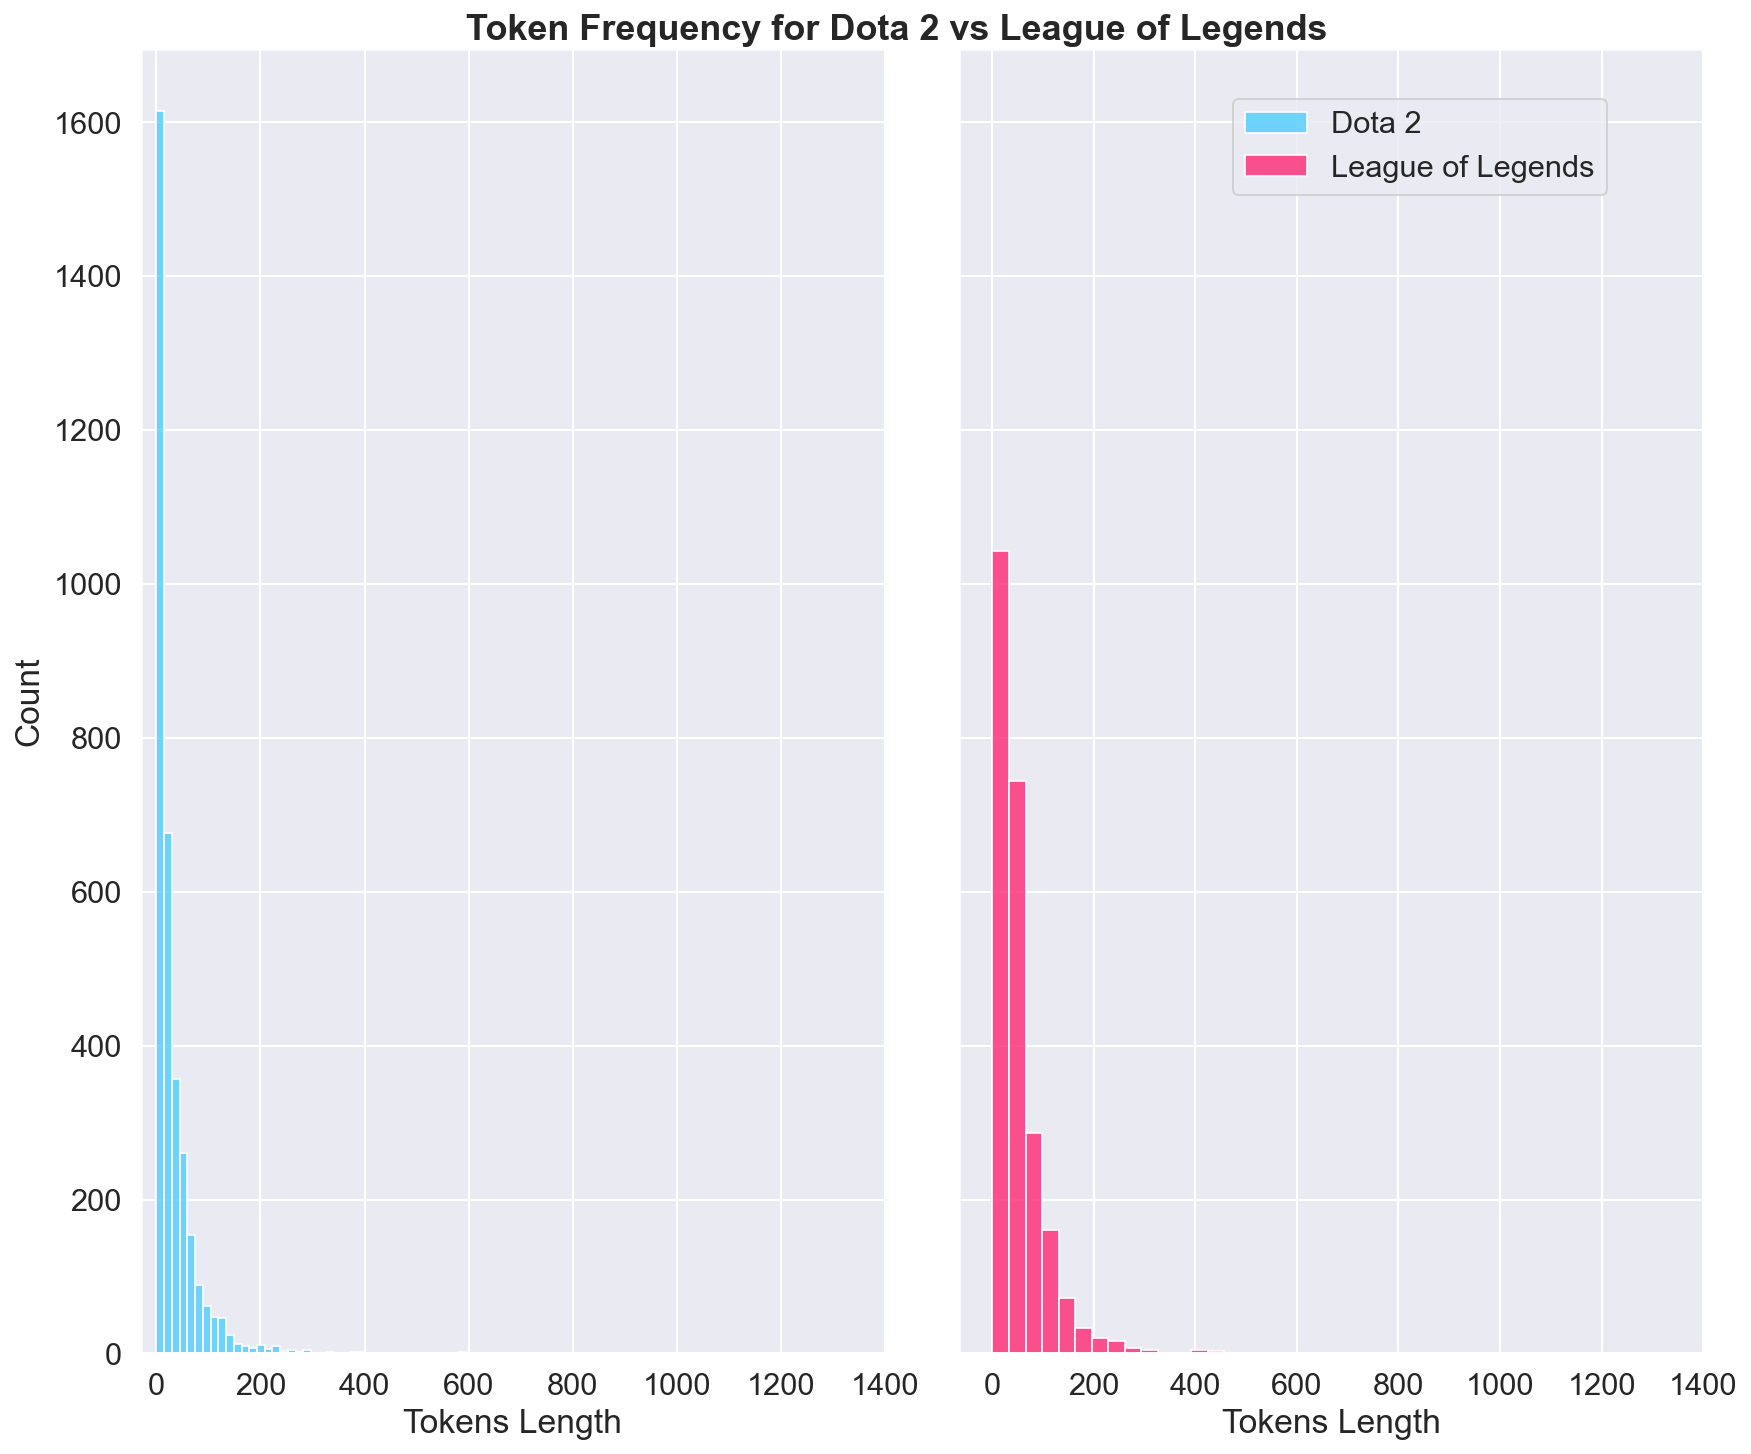

In [25]:
hist1, hist2 = histsubplots(dota2_lol_c[dota2_lol_c['subreddit'] == 'DotA2']['tokens_len'], 
                            dota2_lol_c[dota2_lol_c['subreddit'] == 'leagueoflegends']['tokens_len'], 
                            label1 = 'Dota 2', label2 = 'League of Legends', 
                            bins_count = 40, title = "Token Frequency for Dota 2 vs League of Legends")

# Set labels for each subplot
hist1.set_xlabel('Tokens Length')
hist1.set_ylabel('Count')
hist2.set_xlabel('Tokens Length')
hist2.set_ylabel('Count')

# Set xaxis' tick locations for each subplot
hist1.set_xticks(range(0, 1600, 200))
hist2.set_xticks(range(0, 1600, 200))

- Most of the titles and/or selftexts for each subreddit have very few tokens or low word count.
- Both subreddits' datasets have a right-skewed or positive-skew distribution, i.e. each has a long right tail in the positive direction on the number line. The mean is also to the right of the peak for each dataset.

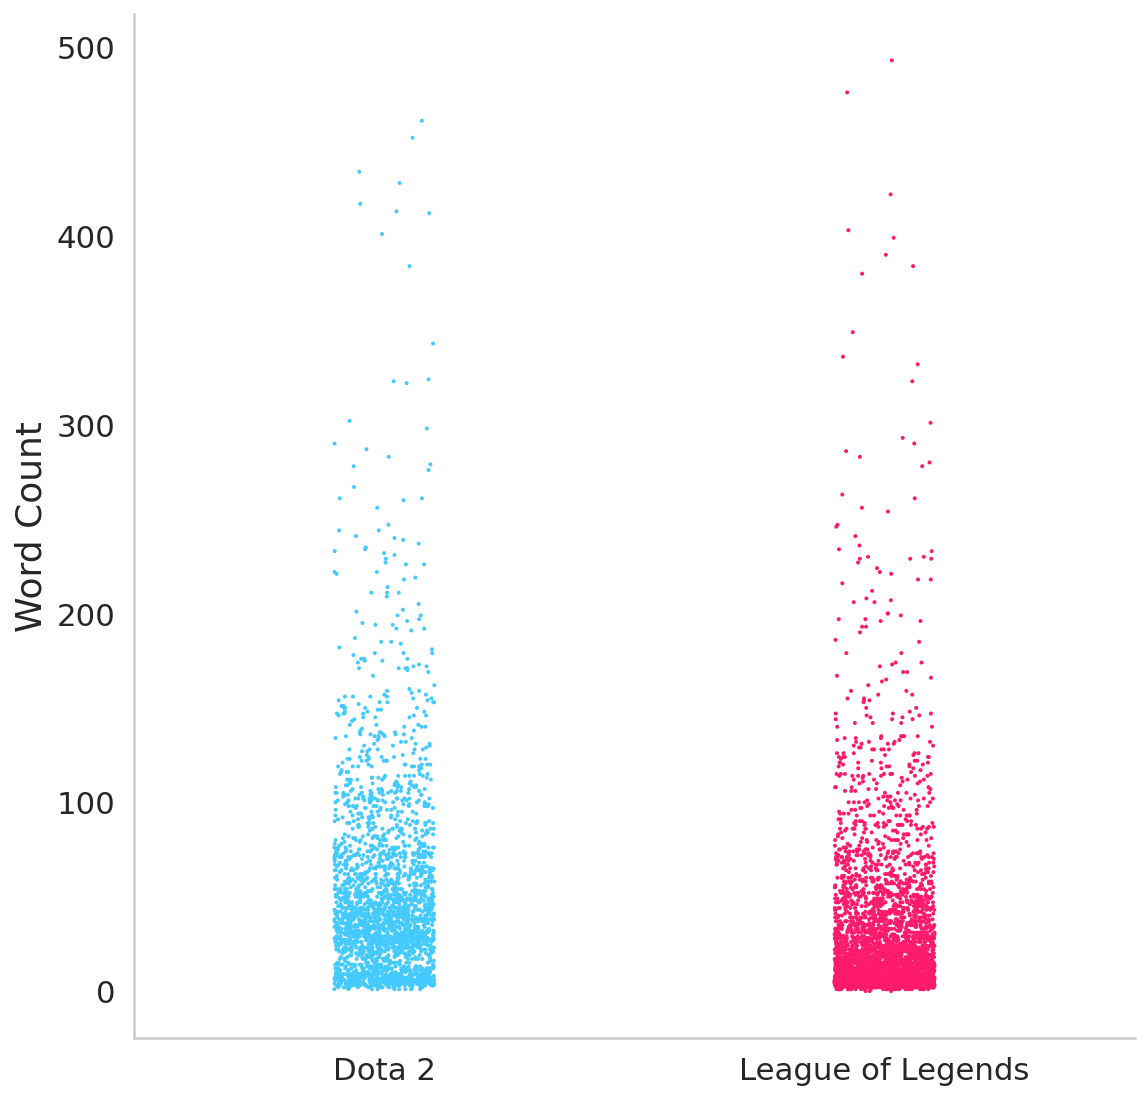

In [26]:
### Histogram Plot (Exploring Distribution)sns.set(font_scale = 2)
sns.set_style("whitegrid", {'axes.grid' : False})

cp = sns.catplot(x = "subreddit", y = "tokens_len", kind = "strip", 
                 data = dota2_lol_c[dota2_lol_c['tokens_len'] < 500].sort_values(by = 'subreddit', ascending = False), 
                 height = 8, s = 2, palette = ['#45CAFF', '#FF1B6B'])

plt.xlabel('', fontsize = 18)
plt.ylabel('Word Count', fontsize = 18)
cp.set_xticklabels(['Dota 2', 'League of Legends'])

sns.reset_orig()

- Since most of the datapoints for each subreddit are concentrated near the bottom of the categorical plot, this indicates that most of the titles and/or selftexts for each subreddit have very few tokens or low word count.

In [27]:
dota2_lol_c[dota2_lol_c['tokens_len'] > 500]['title_selftext'].apply(print)

The story of a boy and a fixed 50% winrate. / Part 3 - Final - John's farewell, part1 [//

part2 [//

There is something I haven't told you about John. I'm not sure why have I left it out before. This event was the trigger that forced John to change his attitude and how he looks at the game.

The events that you are about to read, happened long before John met Yatoro.

It was a typical day in John's life. The night before when he went to bed, he promised himself that next day he will be productive and that the first the he will do in the morning is to sit down and study for a few hours and clean his room. He promised himself that he won't play Dota the next day. It's no surprise that the first thing he actually did in the morning was a nice game of Dota. The best thing you can do to wake up and kickstart your day is a game of Dota, right? Turns out it wasn't.

Please note that there was no rolequeue when this happened. John started Dota, clicked the Find Match button and the clock star

1145    None
1260    None
3554    None
3565    None
3630    None
3755    None
3820    None
4169    None
5487    None
Name: title_selftext, dtype: object

- It is reasonably expected that each subreddit will have a small percentage of members who are passionate about the topic of interest and posts in long form (see above).
- Thus, these posts are generally the outliers and are rich sources of good classification keywords.
- It would be wise to retain these outliers. 

### Data Cleaning: Remove Tokenized Words with customised Stopwords List 

In [28]:
# Data Tokenization: Break raw text strings into individual words
# Download list of English stopwords from the Python Natural Language Toolkit (NLTK) library 
nltk.download('stopwords')

# print(stopwords.words('english'))
stopword = nltk.corpus.stopwords.words('english')

# Extend NLTK English stopwords to include the names of these 2 subreddits and 
# common words between both subreddits that appear most frequently
add_stopwords = ['dota', 'dota2', 'league', 'legends', 'game', 'get', 'like', 'team', 'play', 'player', 'one', 'would', 
                 'dont', 'im', 'time', 'even', 'ampx200b', 'new', 'people', 'know', 'playing', 'make', 'think', 'also', 
                 'really', 'want', 'still', 'got', 'good', 'see', 'every', 'day', 'much', 'win', 'could', 'year', 
                 'match', 'damage', 'go', 'way', 'feel', 'thing', 'enemy', 'first', 'since', 'need', 'cant', 'support', 
                 'back', 'something', 'played', 'item', 'anyone', 'give', 'ive', 'someone', 'say', 'never', 'help', 
                 'doesnt', 'level', 'account', 'bad', 'change', 'fun', 'second', 'best', 'work', 'right', 'ranked', 
                 'better', 'lot', 'last', 'lane', 'post', 'well', 'point', 'friend', 'around', 'take', 'mid', 'many', 
                 'guy', 'group', 'going', 'getting', 'spell', 'issue', 'kill', 'idea', 'always', 'actually', 'look', 
                 'without', 'hard', 'use', 'role', 'didnt', 'find', 't1', 'bug', 'everyone', 'patch', 'looking', 
                 'sure', 'reason', 'pick', 'ever', 'thought', 'let', 'ability', 'able', 'already', 'rank', 'video', 
                 'start', 'used', 'queue', 'skill', 'anything', 'maybe', 'try', 'two', 'else', 'long', 'high', 
                 'another', 'started', 'love', 'made', 'may', 'end', 'server', 'tournament', 'update', 'come', 'show', 
                 'keep', 'next', 'please', 'event', 'esports', 'today', 'mean', 'pretty', 'main', 'said', 'attack', 
                 'low', 'question', 'minute', 'lose', 'seems', 'thats', 'fight', 'trying', 'might', 'eg', 'fix', 'etc', 
                 'watch', 'great', 'pro', 'old', 'single', 'build', 'hour', 'went', 'region', 'put', 'nothing', 'chat', 
                 'different', 'lost', 'ban', 'nothing', 'bot', 'literally', 'wanted', 'buy', 'place', 'name', 'top', 
                 'probably', 'tell', 'gt', 'tried', 'hit', 'hope', 'pas', 'teammate', 'ago', 'toxic', 'part', 
                 'everything', 'system', 'big', 'death', 'thanks', 'comment', 'hello', 'watching', 'month', 'life', 
                 'youtube', 'stop', 'shit', 'enough', 'experience', 'season', 'yet', 'current', 'range', 'normal', 
                 'little', 'wrong', 'winning', 'making', 'title', 'based', 'carry', 'add', 'hp', 'id', 'currently', 
                 'usually', 'fucking', 'wont', 'live', 'completely', 'base', 'however', 'free', 'loss', 'chinese', 
                 'done', 'lower', 'though', 'jungle', 'community', 'strong', 'youre', 'nice', 'gain', 'world', 'lol', 
                 'working', 'chance', 'meta', 'hi', 'losing', 'double', 'ask', 'gold', 'twitter', 'run', 'target', 
                 'whats', 'mistake', 'favorite', 'example', 'recently', 'left']
stopword.extend(add_stopwords)

# Remove Tokenized Words found in NLTK's List of English Stopwords and Extended Stopwords
dota2_lol_c['ts_nostop'] = dota2_lol_c['ts_token'].apply(lambda x: del_stopwords(x, stopword))
dota2_lol_c[['subreddit', 'ts_token', 'ts_nostop']]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\boonl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


subreddit                                                                                             ts_token                                                                                            ts_nostop
0               DotA2  [how, are, teams, justifying, picking, mars, when, his, winrate, in, tournaments, is, always, be...  [teams, justifying, picking, mars, winrate, tournaments, picking, mars, except, bkb, piercing, a...
1               DotA2                                                            [where, is, ti10, true, sight, as, title]                                                                                  [ti10, true, sight]
2               DotA2                      [relationship, with, w33, is, over, ceb, is, my, new, best, friend, windrunner]                                                                 [relationship, w33, ceb, windrunner]
3               DotA2  [create, time, machine, and, go, to, before, covid, to, tell, them, this, go, to, and, tell, eve...  [create, machine, covid, timeline, major, thunder, awakens, tundra, tsm, gaimin, gladiators, bea...
4               DotA2                                                            [revengeance, status, dark, seer, rising]                                                            [revengeance, status, dark, seer, rising]
...               ...                                                                                                  ...                                                                                                  ...
5813  leagueoflegends  [for, every, update, new, bug, its, that, time, of, the, month, new, update, and, its, big, one,...   [supports, feed, image, terrible, alignment, achievements, loading, screen, supports, image, feed]
5814  leagueoflegends  [why, does, support, always, go, bot, lane, curious, why, support, always, goes, bot, lane, with...                               [curious, goes, adc, supports, roam, whatnot, goes, matchup, specific]
5815  leagueoflegends  [where, is, the, option, to, skip, this, progression, page, post, game, idgaf, get, this, crap, ...  [option, skip, progression, page, idgaf, crap, screen, care, whatever, halfassed, implemented, s...
5816  leagueoflegends  [how, do, you, find, the, pbe, gameplay, so, far, from, the, durability, changes, any, surprises...  [pbe, gameplay, far, durability, changes, surprises, space, discussion, figured, changes, hold, ...
5817  leagueoflegends                                            [what, are, the, best, picks, for, top, lane, in, season]                                                                                              [picks]

[5818 rows x 3 columns]

### Data Lemmatization

In [29]:
# Download WordNet corpus reader from the Python Natural Language Toolkit (NLTK) library
# which gives access to the Open Multilingual WordNet (OMW) using ISO-639 language codes.
nltk.download('wordnet')
# Download OMW 1.4 from the Python Natural Language Toolkit (NLTK) library
nltk.download('omw-1.4')

# Lemmatize Tokens Without Stopwords and remove Resultant Stopwords, if any
dota2_lol_c['ts_lemmatized'] = dota2_lol_c['ts_nostop'].apply(lambda x: lemmatize(x))
dota2_lol_c['ts_lemmatized'] = dota2_lol_c['ts_lemmatized'].apply(lambda x: del_stopwords(x, stopword))
dota2_lol_c[['subreddit', 'ts_nostop', 'ts_lemmatized']]

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\boonl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\boonl\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


subreddit                                                                                            ts_nostop                                                                                        ts_lemmatized
0               DotA2  [teams, justifying, picking, mars, winrate, tournaments, picking, mars, except, bkb, piercing, a...  [justifying, picking, mar, winrate, picking, mar, except, bkb, piercing, argue, lack, instant, r...
1               DotA2                                                                                  [ti10, true, sight]                                                                                  [ti10, true, sight]
2               DotA2                                                                 [relationship, w33, ceb, windrunner]                                                                 [relationship, w33, ceb, windrunner]
3               DotA2  [create, machine, covid, timeline, major, thunder, awakens, tundra, tsm, gaimin, gladiators, bea...  [create, machine, covid, timeline, major, thunder, awakens, tundra, tsm, gaimin, gladiator, beas...
4               DotA2                                                            [revengeance, status, dark, seer, rising]                                                            [revengeance, status, dark, seer, rising]
...               ...                                                                                                  ...                                                                                                  ...
5813  leagueoflegends   [supports, feed, image, terrible, alignment, achievements, loading, screen, supports, image, feed]                        [feed, image, terrible, alignment, achievement, loading, screen, image, feed]
5814  leagueoflegends                               [curious, goes, adc, supports, roam, whatnot, goes, matchup, specific]                                                     [curious, adc, roam, whatnot, matchup, specific]
5815  leagueoflegends  [option, skip, progression, page, idgaf, crap, screen, care, whatever, halfassed, implemented, s...  [option, skip, progression, page, idgaf, crap, screen, care, whatever, halfassed, implemented, s...
5816  leagueoflegends  [pbe, gameplay, far, durability, changes, surprises, space, discussion, figured, changes, hold, ...  [pbe, gameplay, far, durability, surprise, space, discussion, figured, hold, discussion, thread,...
5817  leagueoflegends                                                                                              [picks]                                                                                                   []

[5818 rows x 3 columns]

### Data Stemming

In [30]:
# Stem Tokens Without Stopwords and remove Resultant Stopwords, if any
dota2_lol_c['ts_stemmed'] = dota2_lol_c['ts_nostop'].apply(lambda x: stemming(x))
dota2_lol_c['ts_stemmed'] = dota2_lol_c['ts_stemmed'].apply(lambda x: del_stopwords(x, stopword))
dota2_lol_c[['subreddit', 'ts_nostop', 'ts_lemmatized', 'ts_stemmed']]

subreddit                                                                                            ts_nostop                                                                                        ts_lemmatized                                                                                           ts_stemmed
0               DotA2  [teams, justifying, picking, mars, winrate, tournaments, picking, mars, except, bkb, piercing, a...  [justifying, picking, mar, winrate, picking, mar, except, bkb, piercing, argue, lack, instant, r...  [justifi, mar, winrat, mar, except, bkb, pierc, abil, argu, lack, instant, reliabl, stun, fit, l...
1               DotA2                                                                                  [ti10, true, sight]                                                                                  [ti10, true, sight]                                                                                  [ti10, true, sight]
2               DotA2                                                                 [relationship, w33, ceb, windrunner]                                                                 [relationship, w33, ceb, windrunner]                                                                   [relationship, w33, ceb, windrunn]
3               DotA2  [create, machine, covid, timeline, major, thunder, awakens, tundra, tsm, gaimin, gladiators, bea...  [create, machine, covid, timeline, major, thunder, awakens, tundra, tsm, gaimin, gladiator, beas...  [creat, machin, covid, timelin, major, thunder, awaken, tundra, tsm, gaimin, gladiat, beastcoast...
4               DotA2                                                            [revengeance, status, dark, seer, rising]                                                            [revengeance, status, dark, seer, rising]                                                                    [reveng, statu, dark, seer, rise]
...               ...                                                                                                  ...                                                                                                  ...                                                                                                  ...
5813  leagueoflegends   [supports, feed, image, terrible, alignment, achievements, loading, screen, supports, image, feed]                        [feed, image, terrible, alignment, achievement, loading, screen, image, feed]                                       [feed, imag, terribl, align, achiev, load, screen, imag, feed]
5814  leagueoflegends                               [curious, goes, adc, supports, roam, whatnot, goes, matchup, specific]                                                     [curious, adc, roam, whatnot, matchup, specific]                                              [curiou, goe, adc, roam, whatnot, goe, matchup, specif]
5815  leagueoflegends  [option, skip, progression, page, idgaf, crap, screen, care, whatever, halfassed, implemented, s...  [option, skip, progression, page, idgaf, crap, screen, care, whatever, halfassed, implemented, s...          [option, skip, progress, page, idgaf, crap, screen, care, whatev, halfass, implement, skip]
5816  leagueoflegends  [pbe, gameplay, far, durability, changes, surprises, space, discussion, figured, changes, hold, ...  [pbe, gameplay, far, durability, surprise, space, discussion, figured, hold, discussion, thread,...  [pbe, gameplay, far, durabl, chang, surpris, space, discuss, figur, chang, hold, discuss, thread...
5817  leagueoflegends                                                                                              [picks]                                                                                                   []                                                                                                   []

[5818 rows x 4 columns]

### Sentence Forming with Processed Tokens

In [31]:
# Form Sentences with Processed Tokens
dota2_lol_c.loc[:, 'ts_lemm_sentence'] = dota2_lol_c['ts_lemmatized'].apply(lambda x: ' '.join(map(str, x)))
dota2_lol_c.loc[:, 'ts_stem_sentence'] = dota2_lol_c['ts_stemmed'].apply(lambda x: ' '.join(map(str, x)))
dota2_lol_c = dota2_lol_c.fillna('')
dota2_lol_c.loc[:, 'ts_lemm_sentence']

0       justifying picking mar winrate picking mar except bkb piercing argue lack instant reliable stun ...
1                                                                                           ti10 true sight
2                                                                           relationship w33 ceb windrunner
3       create machine covid timeline major thunder awakens tundra tsm gaimin gladiator beastcoast betbo...
4                                                                       revengeance status dark seer rising
                                                       ...                                                 
5813                                    feed image terrible alignment achievement loading screen image feed
5814                                                              curious adc roam whatnot matchup specific
5815                option skip progression page idgaf crap screen care whatever halfassed implemented skip
5816    pbe gameplay far dur

### Visualising Most Frequent Words

In [32]:
def barsubplots(data1, data2, title = '', xlabel = ''):
    fig, axes = plt.subplots(1, 2, figsize = (14, 12), sharex = True)      # sharex = True --> Identical x-axis scales
   
    # Default y = 0.98, Reduce y value to lift Title above charts
    fig.suptitle(title, y = 0.95, fontsize = 18, fontweight = 'bold') 

    sp1 = data1.plot(kind = 'barh', y = 'value', x = 'feature_name', ax = axes[0], label='_', 
                     fontsize = 12, color = '#45CAFF');
    sp2 = data2.plot(kind = 'barh', y = 'value', x = 'feature_name', ax = axes[1], label='_', 
                     fontsize = 12, color = '#FF1B6B');
        
    plt.subplots_adjust(wspace = 0.8)
    
    sp1.set_xlabel(xlabel, fontsize = 12)
    sp1.set_ylabel('Words', fontsize = 12)
    sp1.set_title('Dota 2')
    sp2.set_xlabel(xlabel, fontsize = 12)
    sp2.set_ylabel('Words', fontsize = 12)
    sp2.set_title('League of Legends')
    
    return sp1, sp2

### Count Vectorization

(<AxesSubplot:title={'center':'Dota 2'}, xlabel='Count', ylabel='Words'>,
 <AxesSubplot:title={'center':'League of Legends'}, xlabel='Count', ylabel='Words'>)

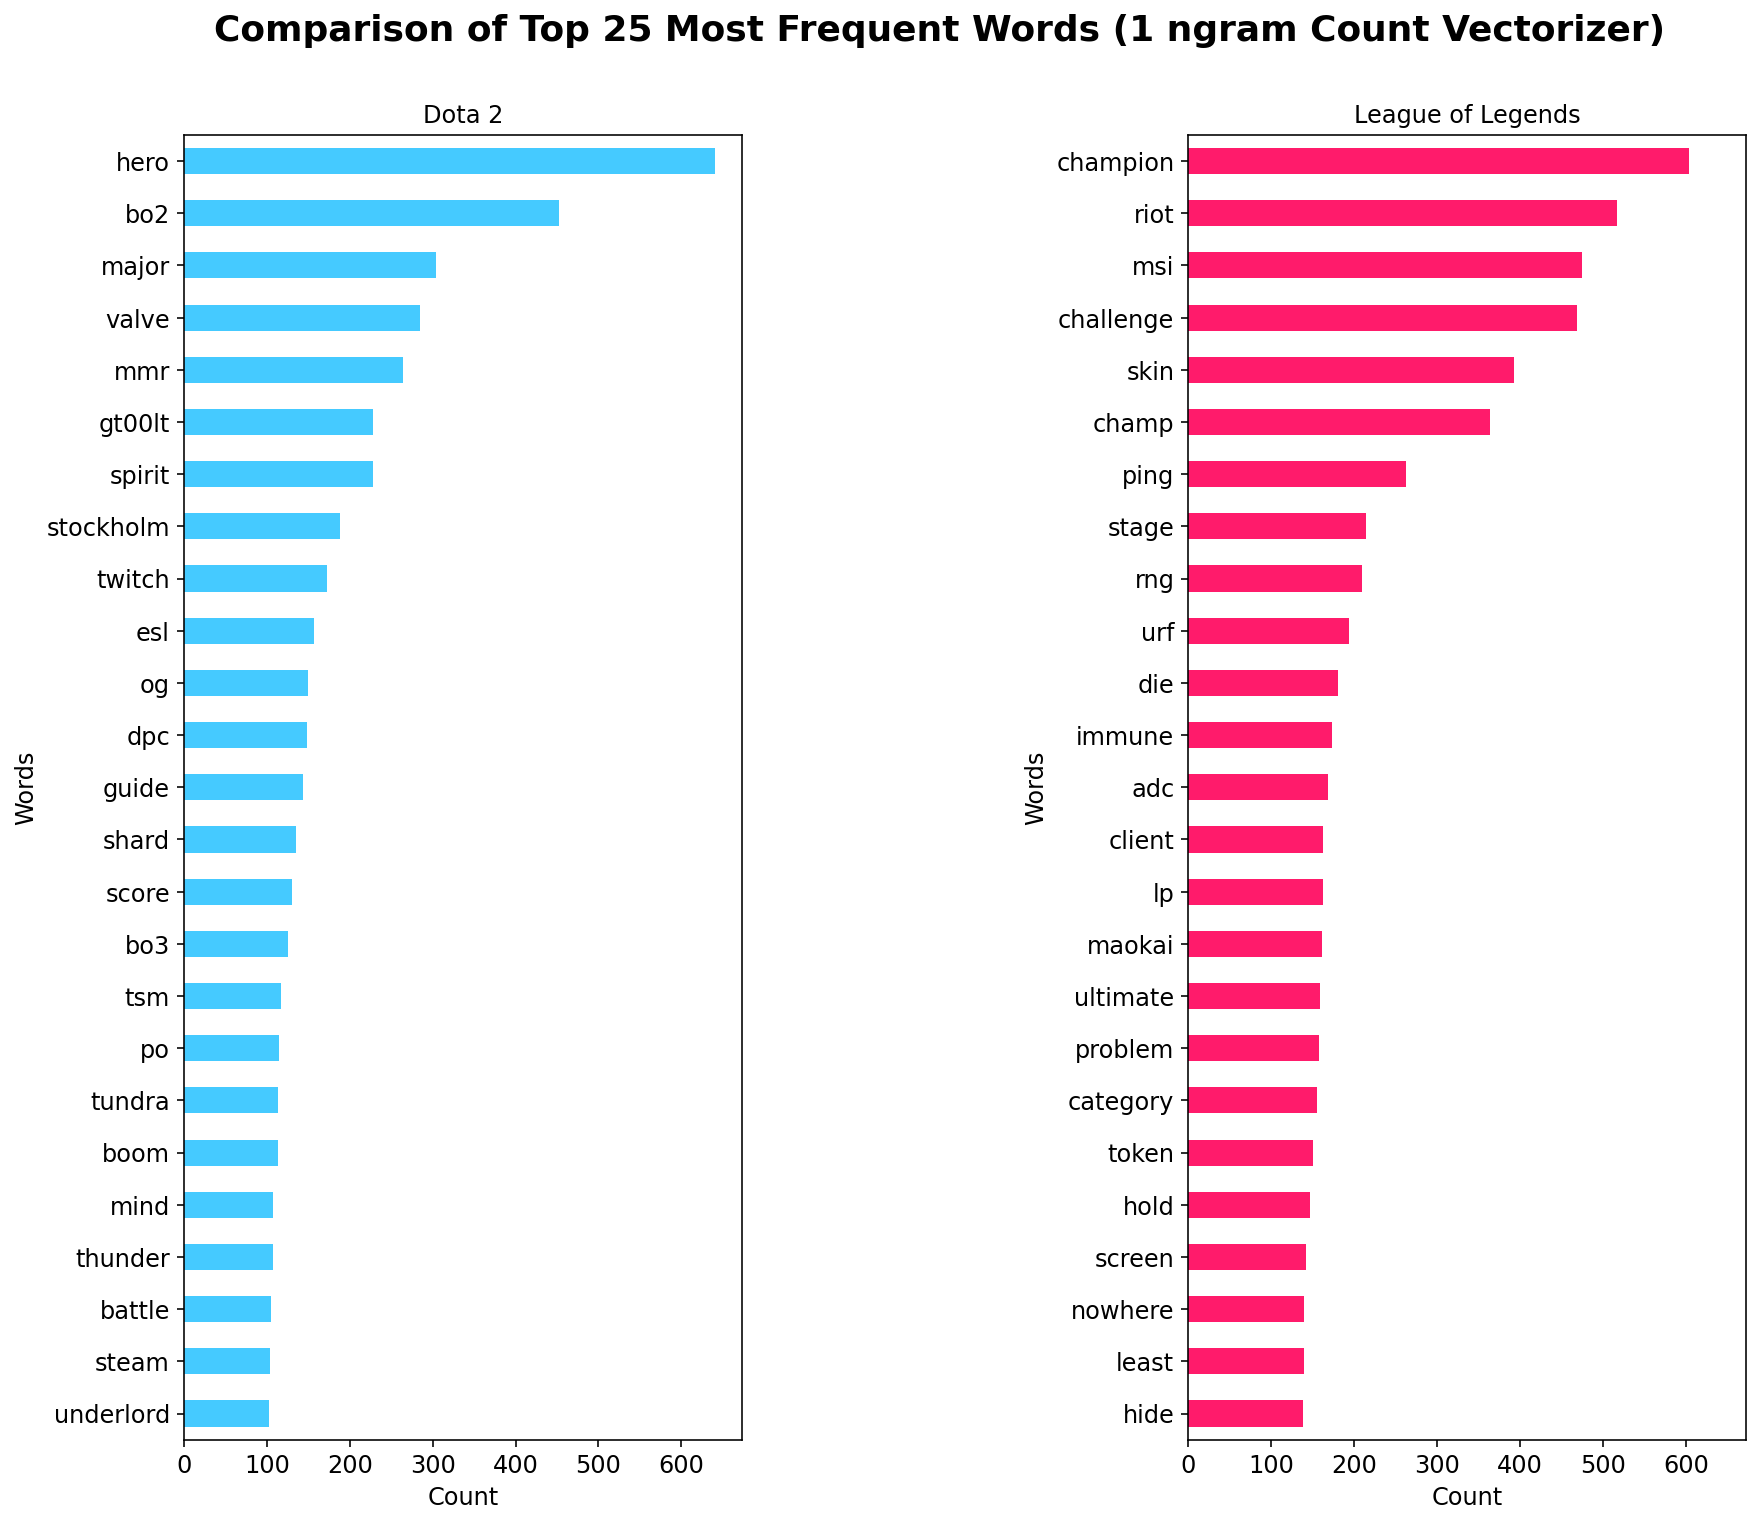

In [33]:
#### Count Vectorization: Lemmatized Tokens (1 ngram)
# ngram_range refers to the range of n-grams that we would like to look for. In this case, (2,2) = bigrams only
# (1,3) will return unigram, bigram, trigram since lower limit is 1 and upper limit is 3
cvec1 = CountVectorizer(ngram_range = (1 , 1))

dota2_cvec_lem1 = pd.DataFrame(cvec1.fit_transform(dota2_lol_c[dota2_lol_c['subreddit'] == 'DotA2']['ts_lemm_sentence']).todense(), columns = cvec1.get_feature_names_out())

lol_cvec_lem1 = pd.DataFrame(cvec1.fit_transform(dota2_lol_c[dota2_lol_c['subreddit'] == 'leagueoflegends']['ts_lemm_sentence']).todense(), columns = cvec1.get_feature_names_out())

barsubplots(dota2_cvec_lem1.sum().sort_values(ascending = True).tail(25), 
            lol_cvec_lem1.sum().sort_values(ascending = True).tail(25), 
            title = 'Comparison of Top 25 Most Frequent Words (1 ngram Count Vectorizer)', xlabel = 'Count')

Comparison of the Top 25 highest frequency words  (1 ngram) amongst these 2 popular gaming subreddits yield the following observations:
 - Each in-game character for Dota 2 and League of Legends (LoL) is known as **hero**  ([*source*](https://www.dota2.com/heroes)) and **champion**  ([*source*](https://www.leagueoflegends.com/en-us/champions/)) respectively. Thus, it is naturally expected these 2 words are most frequently mentioned in posts within each subreddit.
 - Both game's player base appears to be intensely competitive and active:
   - Games specific terms/acronyms such as **major** (name of professional Dota 2 esport tournament) ([*source*](https://liquipedia.net/dota2/Dota_Major_Championships)), **mmr** (short for _matchmaking rating_ which indicates player's skill level), **bo2** (_best of 2 matches_) and **bo3** (_best of 3 matches_) appear more often with Dota 2 subreddit.
   - Similarly, words such as **msi** (short for _Mid-Season Invitational_) ([*source*](https://lol.fandom.com/wiki/2022_Mid-Season_Invitational)) and **challenge** (which allows for player to show off their skill on their profile) ([*source*](https://earlygame.com/lol/challenges-profile-progression)) appear more often with LoL subreddit.
 - **valve** ([*Valve Corporation*](https://www.valvesoftware.com/en/)) and **riot** ([*Riot Games*](https://www.riotgames.com/en)) which corresponds to the respective names of each game's developer cum publisher are frequently mentioned in each subreddit too, implying player bases with potentially high loyalty.
 - The most frequently mentioned in-game character for each game are **underlord** ([*source*](https://dota2.fandom.com/wiki/Underlord)) and **maokai** ([*source*](https://www.leagueoflegends.com/en-us/champions/maokai/)) respectively.
 - Dota 2's in-game purchasable item, **shard** ([*Aghanim's Shard*](https://dota2.fandom.com/wiki/Aghanim%27s_Shard)), and  LoL in-game character's ability to gain an immunity to crowd control, **immune** ([*Immune*](https://leagueoflegends.fandom.com/wiki/Category:Immune_champion)), are most frequently mentioned too.

In [34]:
#add_stopwords = ['dota', 'dota2', 'league', 'legends', 'game', 'get', 'like', 'team', 'play', 'player', 'one', 'would', 
#                 'dont', 'im', 'time', 'even', 'ampx200b', 'new', 'people', 'know', 'playing', 'make', 'think', 'also', 
#                 'really', 'want', 'still', 'got', 'good', 'see', 'every', 'day', 'much', 'win', 'could', 'year', 
#                 'match', 'damage', 'go', 'way', 'feel', 'thing', 'enemy', 'first', 'since', 'need', 'cant', 'support', 
#                 'back', 'something', 'played', 'item', 'anyone', 'give', 'ive', 'someone', 'say', 'never', 'help', 
#                 'doesnt', 'level', 'account', 'bad', 'change', 'fun', 'second', 'best', 'work', 'right', 'ranked', 
#                 'better', 'lot', 'last', 'lane', 'post', 'well', 'point', 'friend', 'around', 'take', 'mid', 'many', 
#                 'guy', 'group', 'going', 'getting', 'spell', 'issue', 'kill', 'idea', 'always', 'actually', 'look', 
#                 'without', 'hard', 'use', 'role', 'didnt', 'find', 't1', 'bug', 'everyone', 'patch', 'looking', 
#                 'sure', 'reason', 'pick', 'ever', 'thought', 'let', 'ability', 'able', 'already', 'rank', 'video', 
#                 'start', 'used', 'queue', 'skill', 'anything', 'maybe', 'try', 'two', 'else', 'long', 'high', 
#                 'another', 'started', 'love', 'made', 'may', 'end', 'server', 'tournament', 'update', 'come', 'show', 
#                 'keep', 'next', 'please', 'event', 'esports', 'today', 'mean', 'pretty', 'main', 'said', 'attack', 
#                 'low', 'question', 'minute', 'lose', 'seems', 'thats', 'fight', 'trying', 'might', 'eg', 'fix', 'etc', 
#                 'watch', 'great', 'pro', 'old', 'single', 'build', 'hour', 'went', 'region', 'put', 'nothing', 'chat', 
#                 'different', 'lost', 'ban', 'nothing', 'bot', 'literally', 'wanted', 'buy', 'place', 'name', 'top', 
#                 'probably', 'tell', 'gt', 'tried', 'hit', 'hope', 'pas', 'teammate', 'ago', 'toxic', 'part', 
#                 'everything', 'system', 'big', 'death', 'thanks', 'comment', 'hello', 'watching', 'month', 'life', 
#                 'youtube', 'stop', 'shit', 'enough', 'experience', 'season', 'yet', 'current', 'range', 'normal', 
#                 'little', 'wrong', 'winning', 'making', 'title', 'based', 'carry', 'add', 'hp', 'id', 'currently', 
#                 'usually', 'fucking', 'wont', 'live', 'completely', 'base', 'however', 'free', 'loss', 'chinese', 
#                 'done', 'lower', 'though', 'jungle', 'community', 'strong', 'youre', 'nice', 'gain', 'world', 'lol', 
#                 'working', 'chance', 'meta', 'hi', 'losing', 'double', 'ask', 'gold', 'twitter', 'run', 'target', 
#                 'whats', 'mistake', 'favorite', 'example', 'recently', 'left']
#stopword.extend(add_stopwords)
# Extend NLTK English stopwords to include the names of these 2 subreddits and 
# common words between both subreddits that appear most frequently

# Remove Tokenized Words found in NLTK's List of English Stopwords and Extended Stopwords
#dota2_lol_c['ts_nostop'] = dota2_lol_c['ts_token'].apply(lambda x: del_stopwords(x, stopword))

# Lemmatize Tokens Without Stopwords and remove Resultant Stopwords, if any
#dota2_lol_c['ts_lemmatized'] = dota2_lol_c['ts_nostop'].apply(lambda x: lemmatize(x))
#dota2_lol_c['ts_lemmatized'] = dota2_lol_c['ts_lemmatized'].apply(lambda x: del_stopwords(x, stopword))

# Stem Tokens Without Stopwords and remove Resultant Stopwords, if any
#dota2_lol_c['ts_stemmed'] = dota2_lol_c['ts_nostop'].apply(lambda x: stemming(x))
#dota2_lol_c['ts_stemmed'] = dota2_lol_c['ts_stemmed'].apply(lambda x: del_stopwords(x, stopword))

# Form Sentences with Processed Tokens
#dota2_lol_c.loc[:, 'ts_lemm_sentence'] = dota2_lol_c['ts_lemmatized'].apply(lambda x: ' '.join(map(str, x)))
#dota2_lol_c.loc[:, 'ts_stem_sentence'] = dota2_lol_c['ts_stemmed'].apply(lambda x: ' '.join(map(str, x)))
#dota2_lol_c = dota2_lol_c.fillna('')
len(add_stopwords)

263

(<AxesSubplot:title={'center':'Dota 2'}, xlabel='Count', ylabel='Words'>,
 <AxesSubplot:title={'center':'League of Legends'}, xlabel='Count', ylabel='Words'>)

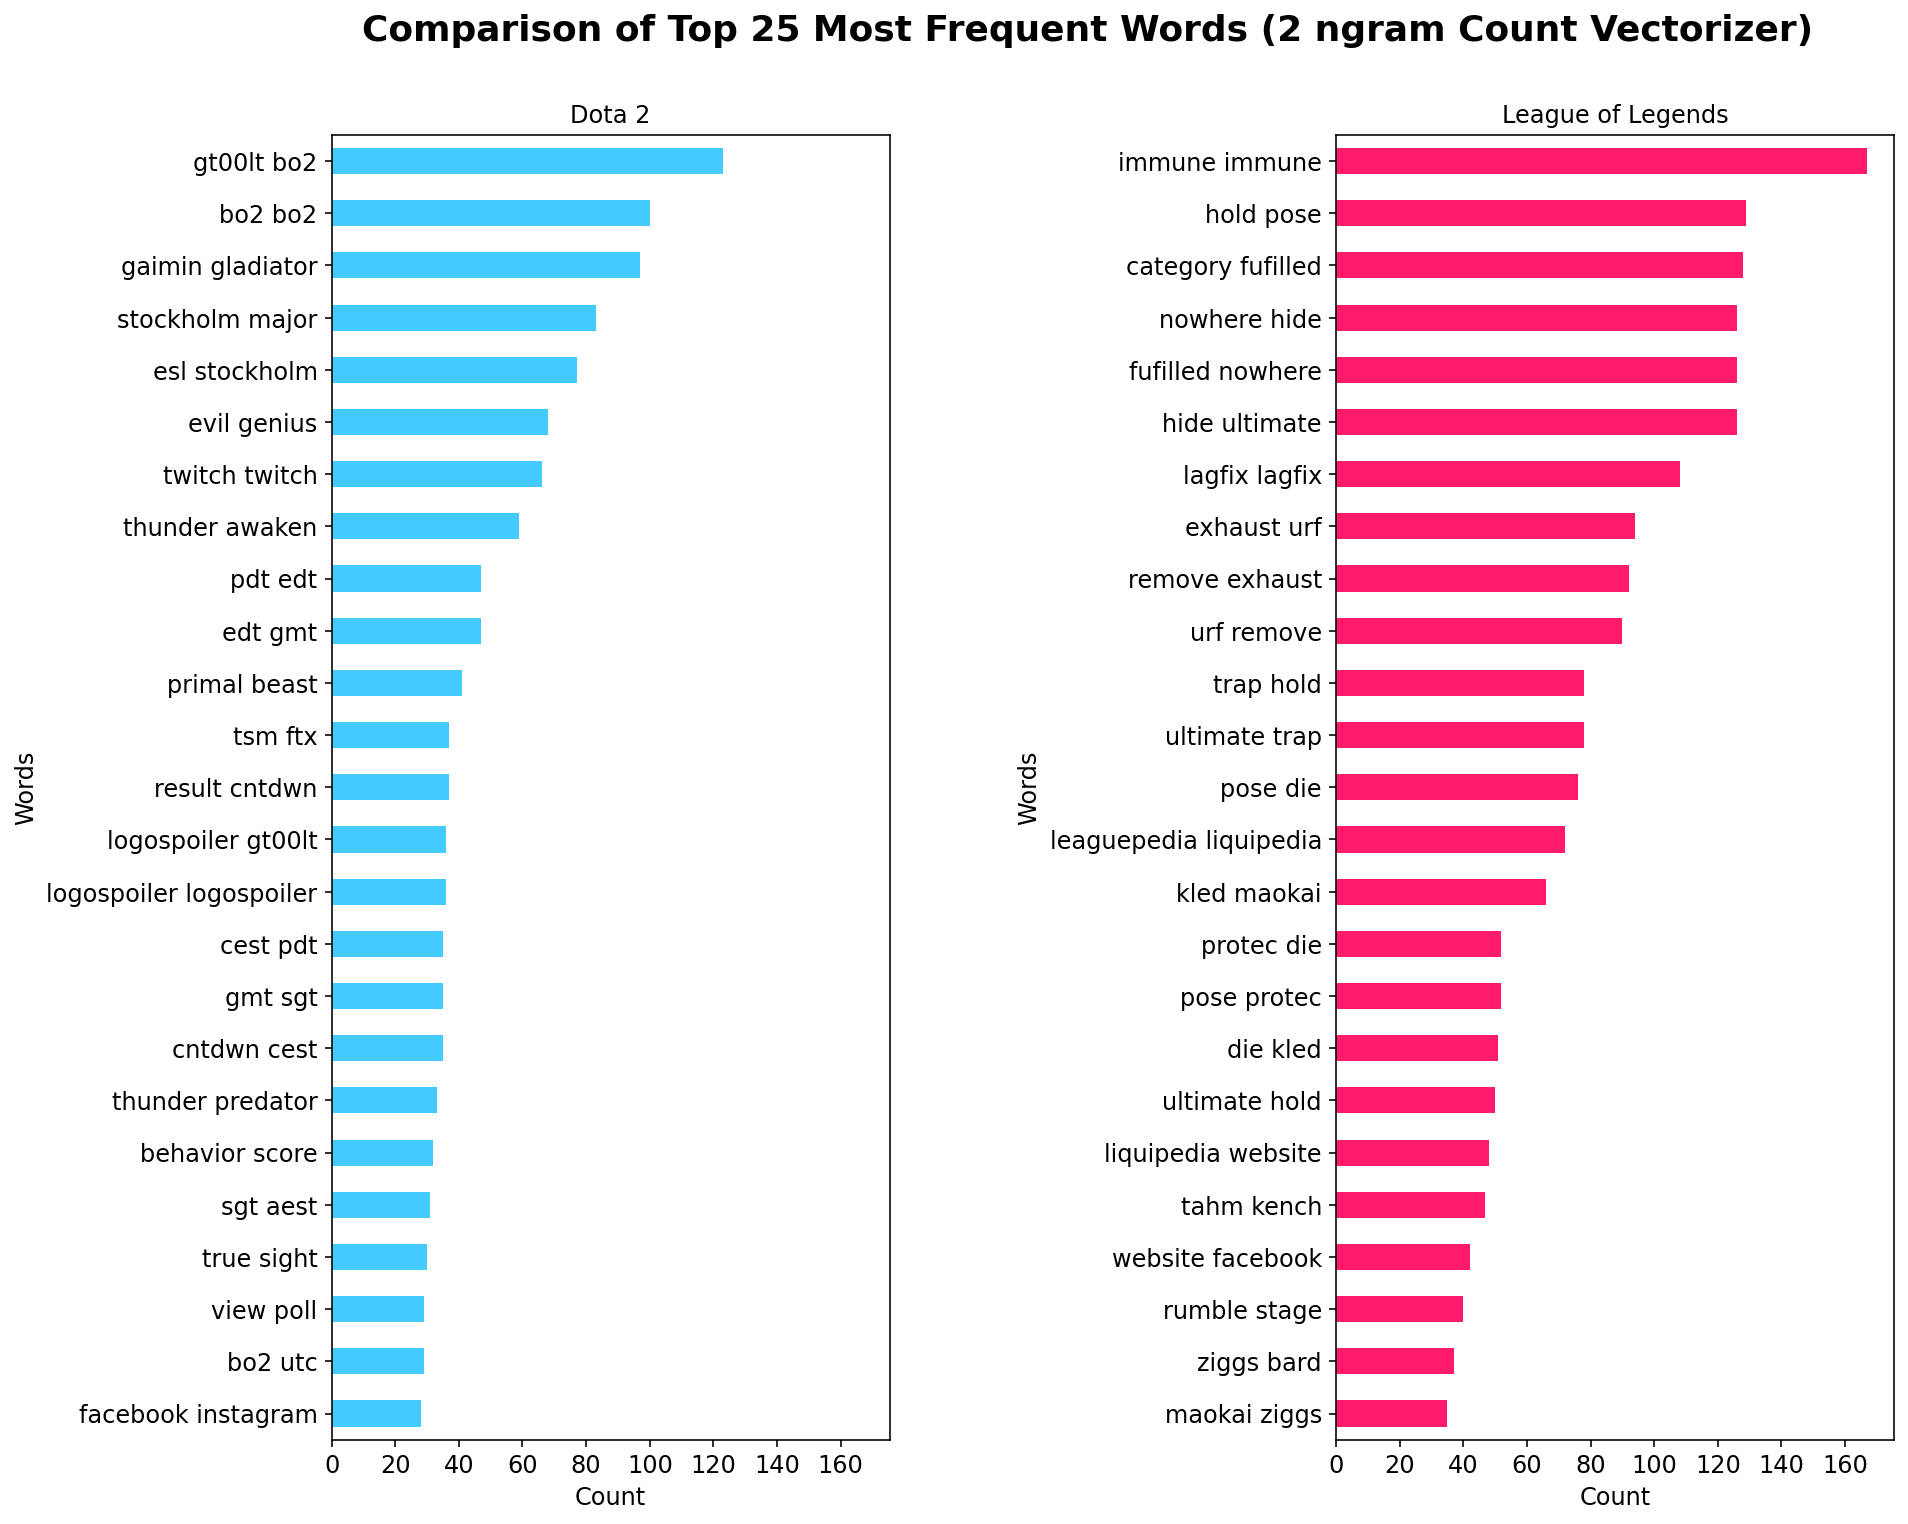

In [35]:
#### Count Vectorization: Lemmatized Tokens (2 ngram)
# ngram_range refers to the range of n-grams that we would like to look for. In this case, (2,2) = bigrams only
# (1,3) will return unigram, bigram, trigram since lower limit is 1 and upper limit is 3
cvec2 = CountVectorizer(ngram_range = (2, 2))

dota2_cvec_lem2 = pd.DataFrame(cvec2.fit_transform(dota2_lol_c[dota2_lol_c['subreddit'] == 'DotA2']['ts_lemm_sentence']).todense(), columns = cvec2.get_feature_names_out())

lol_cvec_lem2 = pd.DataFrame(cvec2.fit_transform(dota2_lol_c[dota2_lol_c['subreddit'] == 'leagueoflegends']['ts_lemm_sentence']).todense(), columns = cvec2.get_feature_names_out())

barsubplots(dota2_cvec_lem2.sum().sort_values(ascending = True).tail(25), 
            lol_cvec_lem2.sum().sort_values(ascending = True).tail(25), 
            title = 'Comparison of Top 25 Most Frequent Words (2 ngram Count Vectorizer)', xlabel = 'Count')

Comparison of the Top 25 highest frequency words (2 ngram) amongst these 2 popular gaming subreddits yield the following observations:
- Generally, 2 ngram results provide greatly details on the context of the highest frequency words in each subreddit than 1 ngram.
 - **gaimin gladiator**(s) is a professional esports organization ([*source*](https://liquipedia.net/dota2/Gaimin_Gladiators)). **Evil Genius**(es) is one of the oldest North American professional gaming organisations ([*source*](https://liquipedia.net/dota2/Evil_Geniuses)). In contrast, the component words of **gaimin**, **gladiator**, **evil** and **genius** may be interpreted differently if and when they appear separately in an 1 ngram.
- Appearance of the word **lagfix** **lagfix** hints of potentially persistent client lag issues ([*source*](https://leaguefeed.net/league-of-legends-client-lag-fix/)).
- Except for Facebook, the social platforms that are more popular amongst users in each subreddit seems to differ somewhat too:
 - Dota 2: Twitch, facebook, and instagram
 - LoL: Leaguepedia ([*source*](https://lol.fandom.com/wiki/League_of_Legends_Esports_Wiki)), liquipedia ([*source*](https://liquipedia.net/)), and facebook
- The most mentioned Dota 2 and LoL characters are **primal beast** ([*source*](https://www.dota2.com/hero/primalbeast)) and, **kled** ([*source*](https://www.leagueoflegends.com/en-pl/champions/kled/)) and **maokai** ([*source*](https://www.leagueoflegends.com/en-pl/champions/maokai/)) respectively.
- Certain matchups between LoL characters seem to be discussed more, e.g. **kled** vs **maokai**
- **stockholm major** and **esl stockholm** are probably referring the same tournament, ESL One Stockholm 2022, which is the first Major of the 2021/2022 Dota Pro Circuit season ([*source*](https://liquipedia.net/dota2/ESL_One/Stockholm/2022)).
- Characters like `&gt;` and `&lt;` (corresponding to `>` and `<` respectively ([*source*](https://dev.w3.org/html5/html-author/charref))) are `HTML Entities` or `Character Entity References` which the browser identifies and replaces with the corresponding reserved character in the HTML (HyperText Markup Language) ([*source*](https://www.educba.com/html-entities/)).
- URL and punctuation removal from html codes in posts resulted in "words" like `gt00lt` appearing twice amongst the top 25 highest frequency words (2 ngram) for Dota 2. The original html block corresponding to `gt00lt` is `&gt;!0:0!&lt;` (See below for 1 such HTML snippet.)

### TF-IDF Vectorization

(<AxesSubplot:title={'center':'Dota 2'}, xlabel='Count', ylabel='Words'>,
 <AxesSubplot:title={'center':'League of Legends'}, xlabel='Count', ylabel='Words'>)

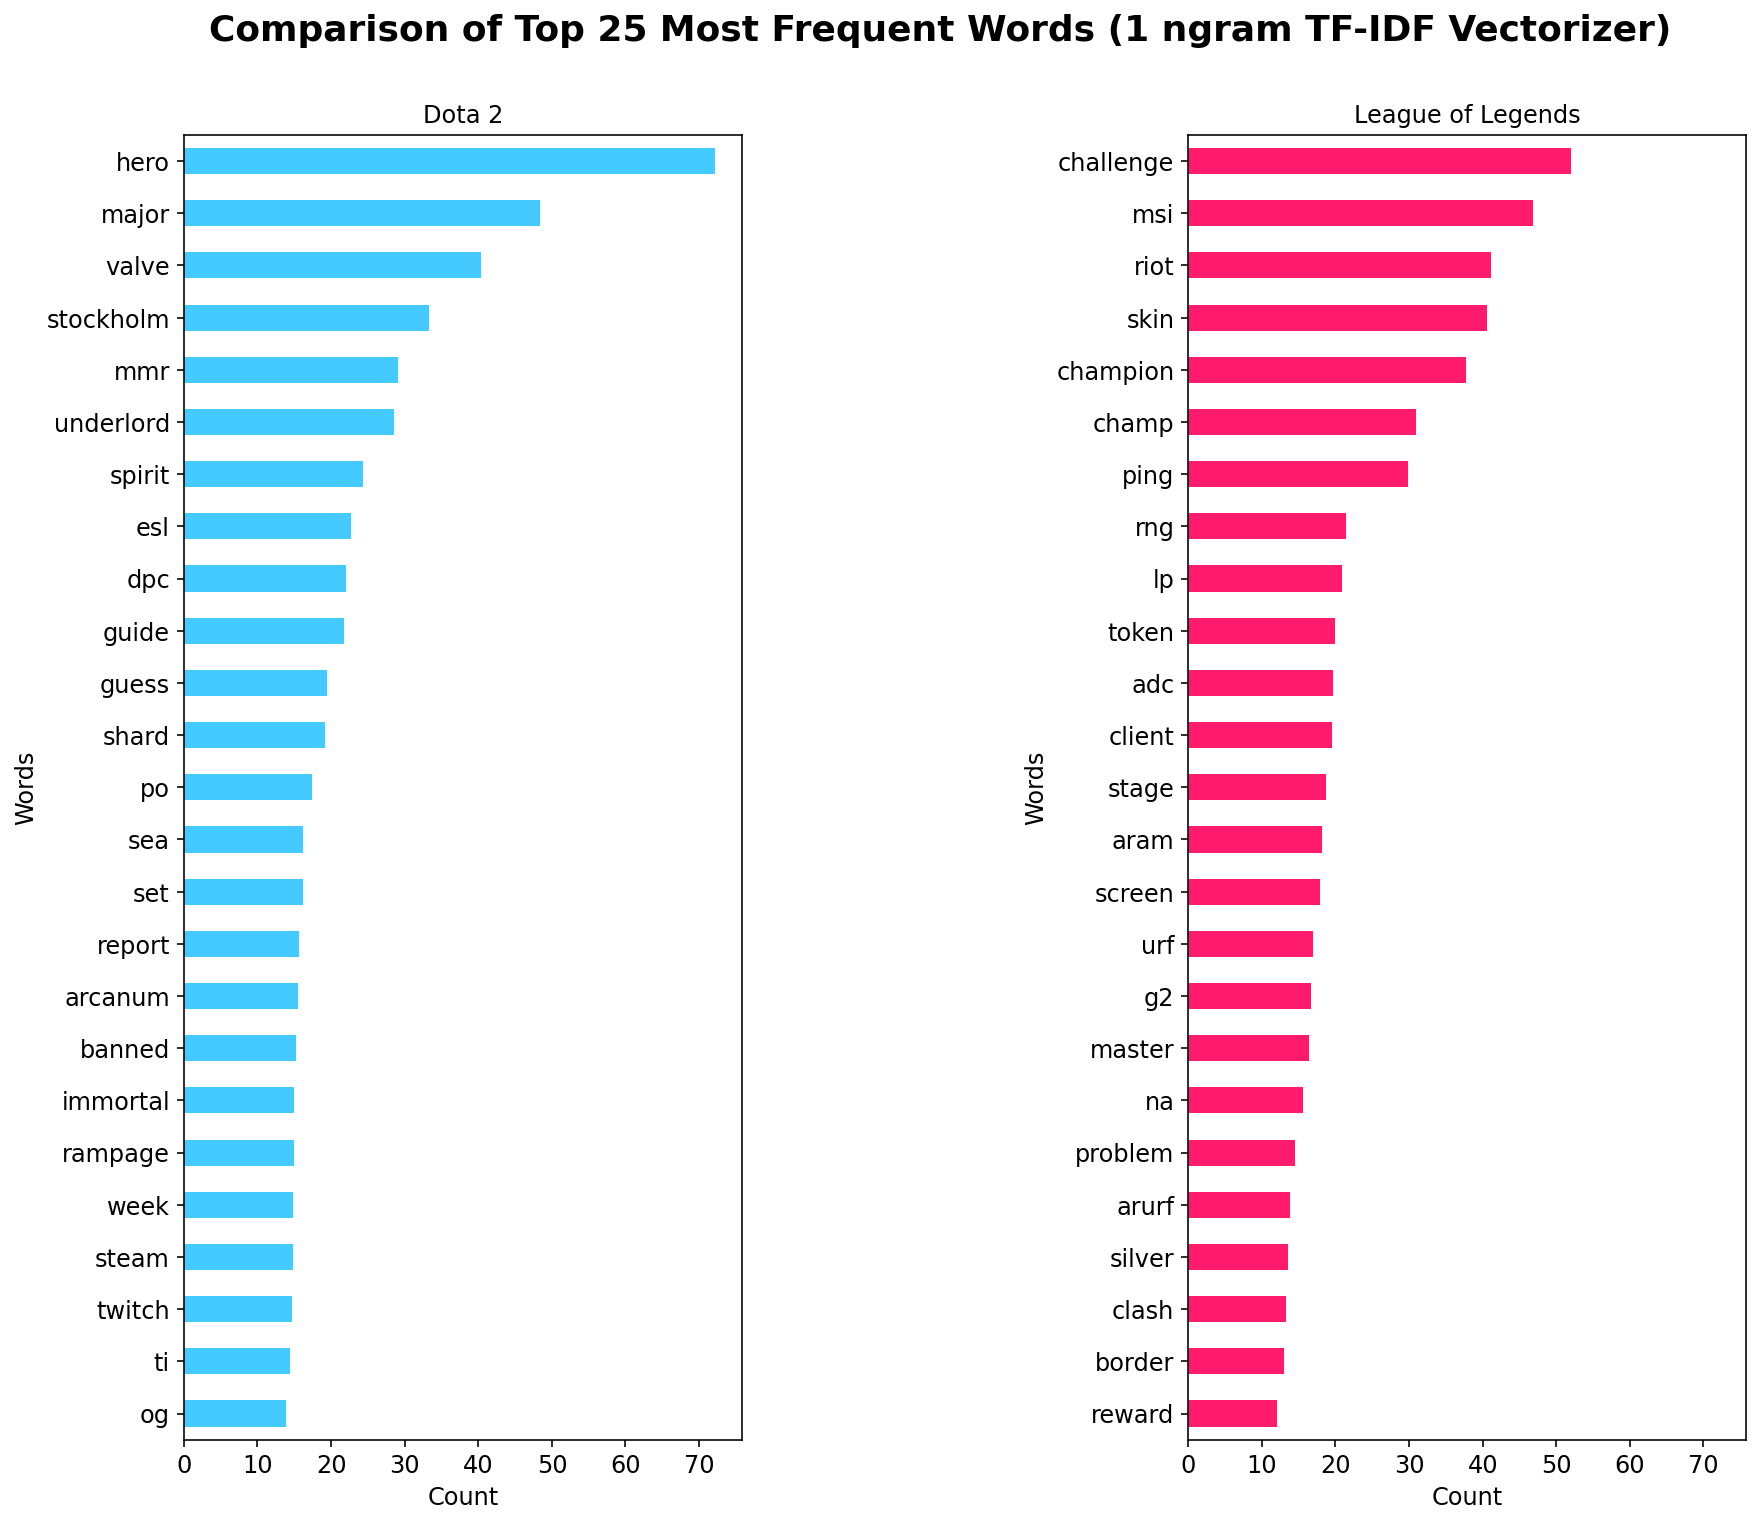

In [36]:
#TF-IDF Vectorizing Lemmatized Tokens (1 ngram)
tvec1 = TfidfVectorizer(ngram_range = (1, 1))

dota2_tfidf_lem1 = pd.DataFrame(tvec1.fit_transform(dota2_lol_c[dota2_lol_c['subreddit'] == 'DotA2']['ts_lemm_sentence']).todense(), columns = tvec1.get_feature_names_out())

lol_tfidf_lem1 = pd.DataFrame(tvec1.fit_transform(dota2_lol_c[dota2_lol_c['subreddit'] == 'leagueoflegends']['ts_lemm_sentence']).todense(), columns = tvec1.get_feature_names_out())

barsubplots(dota2_tfidf_lem1.sum().sort_values(ascending = True).tail(25), 
            lol_tfidf_lem1.sum().sort_values(ascending = True).tail(25), 
            title = 'Comparison of Top 25 Most Frequent Words (1 ngram TF-IDF Vectorizer)', xlabel = 'Count')

Comparison of the Top 25 most frequency words (1 ngram) amongst these 2 popular gaming subreddits identified using count vectorizer (See above) against that using TF-IDF vectorizer yield the following observations:
- Relative importance of most words have changed when comparing between the results obtained
- These differences stem from the count vectorizer merely focuses on the frequency of words present in the corpus while TF-IDF vectorizer also provides the importance of the words in addition to frequency of words present
- Some of the words remained unchanged for each subreddit, e.g.
 - **Dota 2**: hero, major, valve, mmr, spirit, stockholm, twitch, esl, og, dpc, guide, shard, po, steam, underlord
 - **LoL**: champion, riot, msi, challenge, skin, champ, ping, stage, rng, urf, adc, client, lp, problem, token, screen
- For each subreddit, some of the words are present in one vectorizer's results but not the other's, e.g.
 - **For Dota 2**:
   - **Count**: bo2, gt00lt, score, bo3, tsm, tundra, boom, mind, thunder, battle
   - **TF-IDF**: guess, sea, set, report, arcanum, banned, immortal, rampage, week, ti
 - **For LoL**:
   - **Count**: die, immune, maokai, ultimate, category, hold, nowhere, least, hide
   - **TF-IDF**: aram, g2, master, na, arurf, silver, clash, border, reward

(<AxesSubplot:title={'center':'Dota 2'}, xlabel='Count', ylabel='Words'>,
 <AxesSubplot:title={'center':'League of Legends'}, xlabel='Count', ylabel='Words'>)

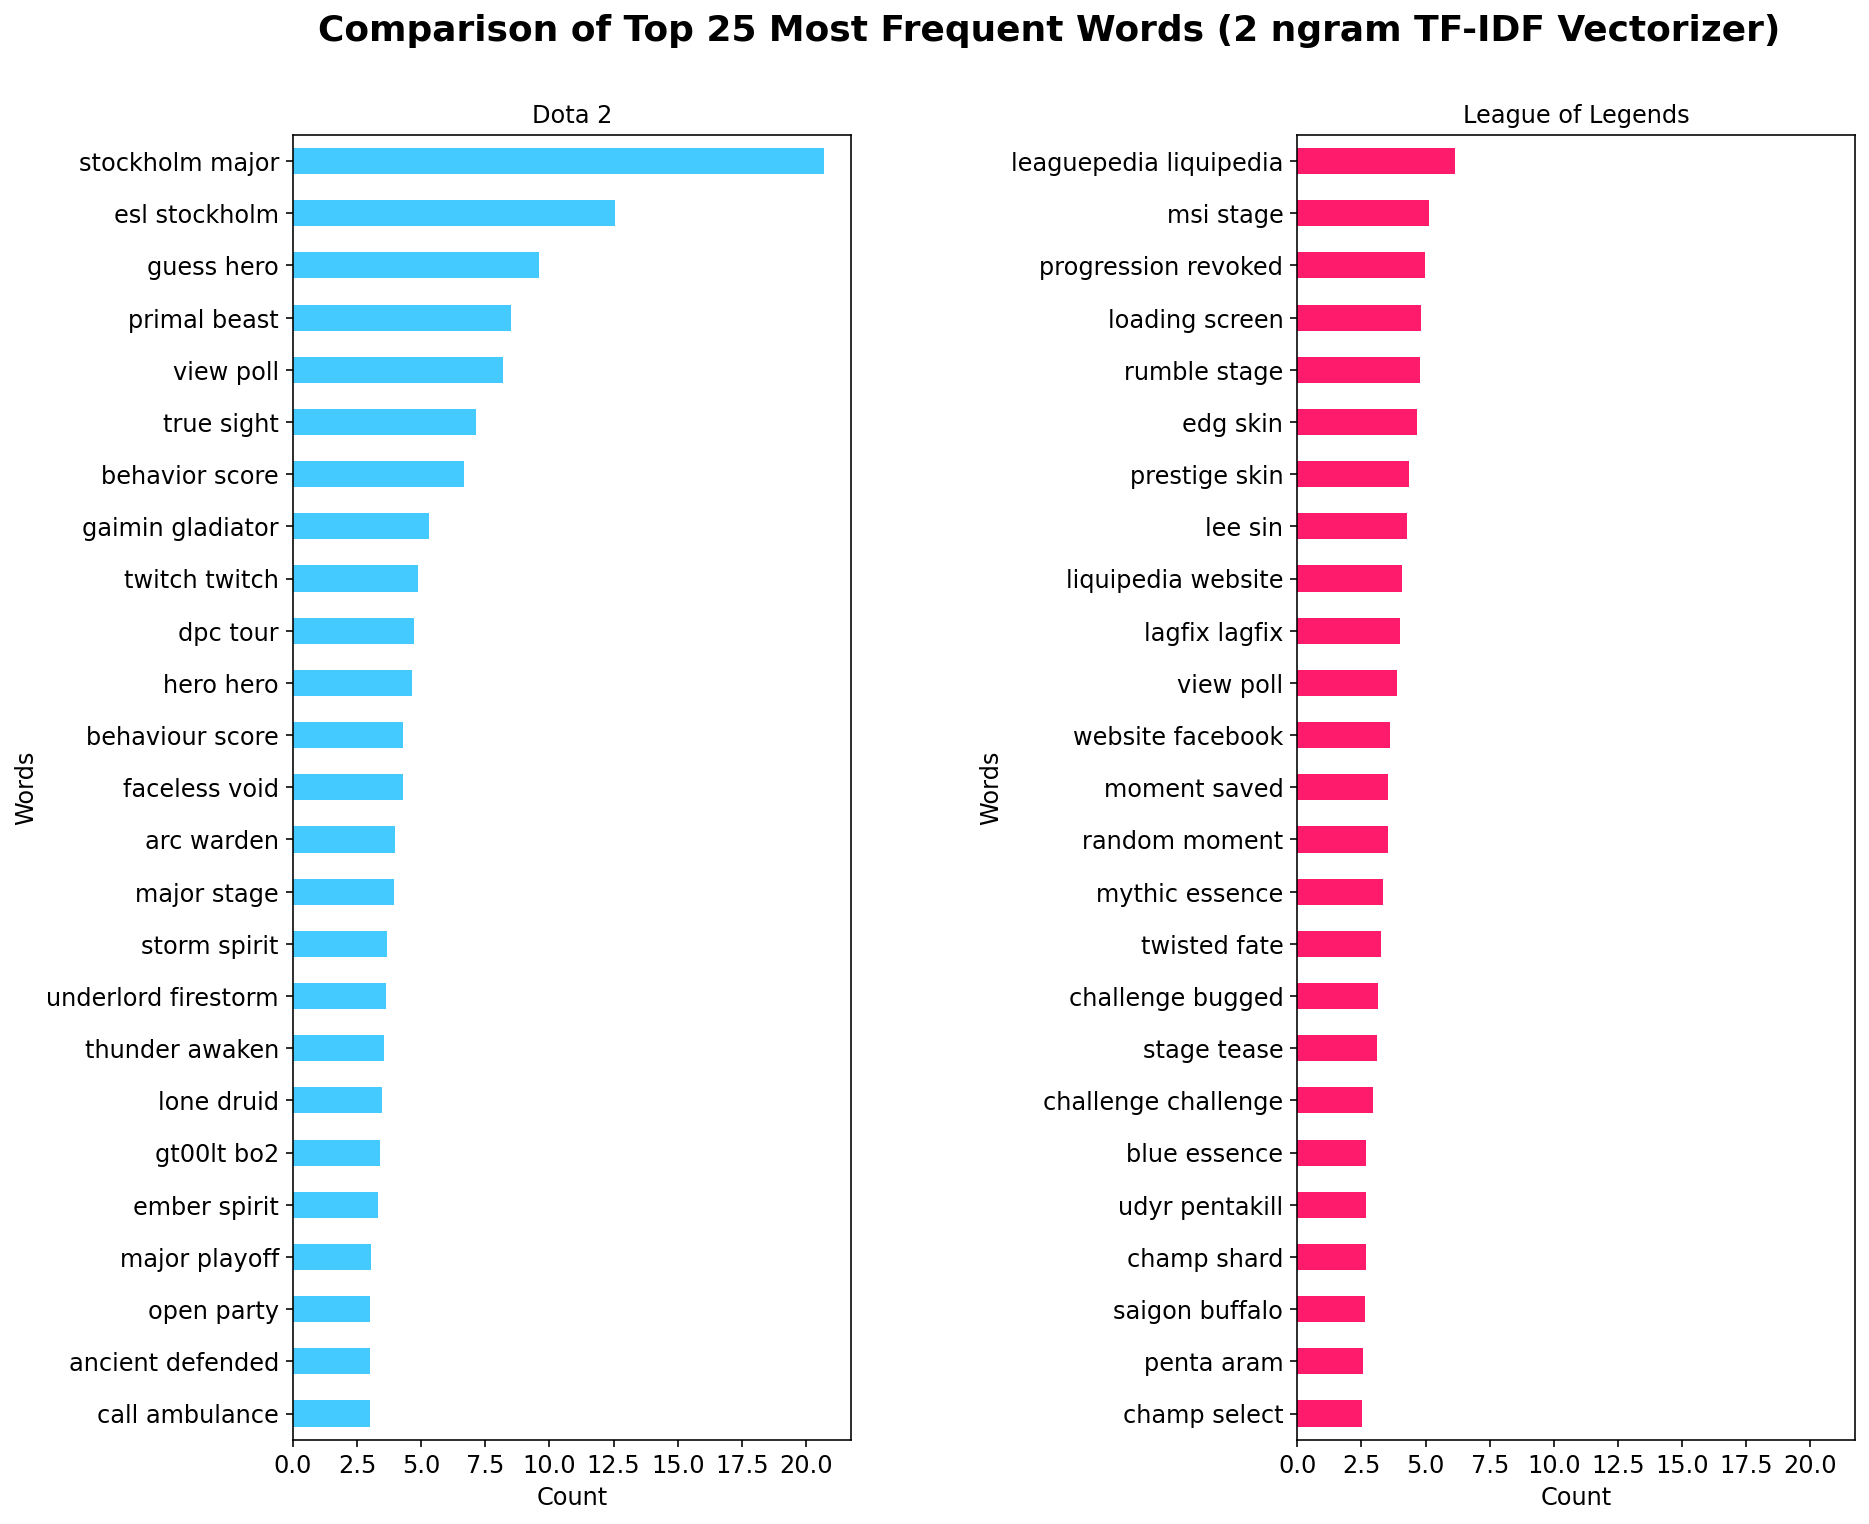

In [37]:
#TF-IDF Vectorizing Lemmatized Tokens (2 ngram)
tvec2 = TfidfVectorizer(ngram_range = (2, 2))

dota2_tfidf_lem2 = pd.DataFrame(tvec2.fit_transform(dota2_lol_c[dota2_lol_c['subreddit'] == 'DotA2']['ts_lemm_sentence']).todense(), columns = tvec2.get_feature_names_out())

lol_tfidf_lem2 = pd.DataFrame(tvec2.fit_transform(dota2_lol_c[dota2_lol_c['subreddit'] == 'leagueoflegends']['ts_lemm_sentence']).todense(), columns = tvec2.get_feature_names_out())

barsubplots(dota2_tfidf_lem2.sum().sort_values(ascending = True).tail(25), 
            lol_tfidf_lem2.sum().sort_values(ascending = True).tail(25), 
            title = 'Comparison of Top 25 Most Frequent Words (2 ngram TF-IDF Vectorizer)', xlabel = 'Count')

Comparison of the Top 25 most frequency words (2 ngram) amongst these 2 popular gaming subreddits identified using count vectorizer (See above) against that using TF-IDF vectorizer yield the following observations:
- Many of the observations from comparing results in 1 ngram for both Count and TF-IDF vectorizers apply here too:
- Relative importance of most words have changed when comparing between the results obtained
- These differences stem from the count vectorizer merely focuses on the frequency of words present in the corpus while TF-IDF vectorizer also provides the importance of the words in addition to frequency of words present
- Some of the words remained unchanged for each subreddit, e.g.
 - **Dota 2**: gt00lt bo2, gaimin gladiator, stockholm major, esl stockholm, twitch twitch, thunder awaken, primal beast, behavior score, true sight, view poll
 - **LoL**: lagfix lagfix, leaguepedia liquidpedia, kled maokai, protec die, pose protec, die kled, liquidpedia website, website facebook, rumble stage
- For each subreddit, some of the words are present in one vectorizer's results but not the other's, e.g.
 - **For Dota 2**:
   - **Count**: evil genius, pdt edt, edt gmt, tsm ftx, result cntdwn, logospoiler gt00lt, logospoiler logospoiler, cest pdt, gmt sgt, cntdwn cest, thunder predator, sgt aest, bo2 utc, facebook instagram
   - **TF-IDF**: guess hero, dpc tour, hero hero, faceless void, arc warden, major stage, storm spirit, underlord firestorm, lone druid, ember spirit, major playoff, open party, ancient defended, call ambulance
 - **For LoL**:
   - **Count**: immune immune, hold pose, category fulfilled, nowhere hide, fulfilled nowhere, hide ultimate, exhaust urf, remove exhaust, urf remove, trap hold, ultimate trap, pose die, ultimate hold, ziggs bard, maokai ziggs
   - **TF-IDF**: msi stage, progression revoked, loading screen, edg skin, prestige skin, lee sin, view poll, moment saved, random moment, mythic essence, twisted fate, challenge bugged, stage tease, challenge challenge, blue essence, udyr pentakill, champ shard, saigon buffalo, penta aram, champ select
<br><br>

- Since we managed to collect a considerable amount of data for both subreddits, with sufficient variety of words for training the various models on, we are likely to be successful in designing an **AI model** that **correctly classifies posts** in the 1 single beta gaming forum thread into 2 separate threads, 1 for Dota 2 and another for League of Legends (LoL), with an **accuracy of at least 85%** and **Top 10 Predictors for each subreddit**.

---

## Model Testing

1. We will perform hyperparameter tuning on these 3 models:
  - Logistic Regression
  - Multinomial Naive Bayes
  - Random Forest Classifier

   using these 2 vectorizers:
  - Count vectorizer
  - TF-IDF vectorizer
<BR>
<BR>    
2. For each model, we will also determine the following:
  - Optimal Grid Search Model Parameters
  - Optimal Grid Search Best Score
  - Train AUC Score
  - Test AUC SCore
  - Train Accuracy Score
  - Test Accuracy Sore
  - Precision
  - Recall or Sensitivcity
  - Specificity
  - F1-Score

   and chart the following:
  - Confusion Matrix
  - Receiver Operating Characteristic (ROC) Curve
<BR>
<BR>    
3. We will also display the top 10 predictors of each model.
    
4. Finally, we will summarise model performance, analyse and determine the most appropriate model for this dataset to address the problem statement. 

In [38]:
# Function to plot ROC AUC curves
def roc_auc_curve(model, X_test_values, y_test_values):
    
    y_pred_proba = model.predict_proba(X_test_values)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_values, y_pred_proba)
    auc = roc_auc_score(y_test_values, y_pred_proba)
    
    plt.rcParams['font.size'] = 14
    plt.plot(fpr, tpr, color = 'navy', label = 'data, auc = ' + str(round(auc, 4)))
    plt.plot(['0', '1'], ['0', '1'], color = 'orange', label = 'baseline', lw = 2, linestyle = '--')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.legend(loc = 4)
    plt.show()
    
    return auc




# Function to display optimal model parameters, Confusion Matrix and ROC Curve
def model_perform(model, X_train_values, y_train_values, X_test_values, y_test_values):
    # Generate predictions
    preds = model.predict(X_test_values)
    
    # Generate Confusion Matrix
    # Documentation here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
    cm = confusion_matrix(y_test_values, preds)
    
    # Save Confusion Matrix values
    tn, fp, fn, tp = confusion_matrix(y_test_values, preds).ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    dict_scores = {'model': str(model.estimator.steps),
                   'gs_best_score': model.best_score_, 
                   'train_auc_score': model.score(X_train_values, y_train_values), 
                   'test_auc_score': model.score(X_test_values, y_test_values), 
                   'train_accuracy_score': accuracy_score(y_train_values, model.predict(X_train_values)), 
                   'test_accuracy_score': accuracy_score(y_test_values, model.predict(X_test_values)), 
                   'f1_score': (2 * recall * precision) / (recall + precision), 
                   'precision': precision, 
                   'sensitivity': recall, 
                   'specificity': tn / (tn + fp)}
    
    print(f"Optimal Grid Search Model Parameters: \n{model.best_params_}\n")
    print(f"Optimal Grid Search Best Score: \n{dict_scores['gs_best_score']}\n")
    print(f"Train AUC Score: \n{dict_scores['train_auc_score']}\n")
    print(f"Test AUC SCore: \n{dict_scores['test_auc_score']}\n")
    print(f"Train Accuracy Score: \n{dict_scores['train_accuracy_score']}\n")
    print(f"Test Accuracy Score: \n{dict_scores['test_accuracy_score']}\n")
    print(f"Precision: \n{dict_scores['precision']}\n")
    print(f"Recall or Sensitivity: \n{dict_scores['sensitivity']}\n")    
    print(f"Specificity: \n{dict_scores['specificity']}\n")
    print(f"F1-Score: \n{dict_scores['f1_score']}\n")

    # Create modified labels for Confusion Matrix
    modified_cm = []
    for index, value in enumerate(confusion_matrix(y_test_values, preds)):
        if index == 0:
            modified_cm.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
        if index == 1:
            modified_cm.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])
            
    # Plot the Confusion Matrix
    plt.figure(figsize = (9, 9))
    sns.heatmap(cm, annot = np.array(modified_cm), 
                fmt = 's',                             # s -string, d - decimal
                annot_kws = {'size': 20}, 
                linewidths = .5, 
                square = True, 
                cmap = 'Blues', 
                xticklabels = ['Dota 2', 'League of Legends'], 
                yticklabels = ['Dota 2', 'League of Legends']
               )
    
    plt.ylabel('Actual Label', fontsize = 16)
    plt.xlabel('Predicted Label', fontsize = 16)
    plt.title('Accuracy: {:.3f}'.format(dict_scores['test_accuracy_score']) + '\n'
              + 'Precision: {:.3f}'.format(dict_scores['precision']) + '\n'
              + 'Recall: {:.3f}'.format(dict_scores['sensitivity']) + '\n'
              + 'F1-Score: {:.3f}'.format(dict_scores['f1_score']) + '\n', size = 16)
    
    plt.tick_params(labelsize = 16)

    # Receiver Operating Characteristic (ROC) Curve
    # Plot the True Positive Rate vs. False Positive Rate for range of possible decision thresholds to get the ROC curve
    plt.figure(figsize = (6, 6));
    auc = roc_auc_curve(model, X_test, y_test);
    plt.show();
    
    return dict_scores



# Function to get most important words based on coefficients of the logistic regression model
def features(vectoriser, estimator, n):
    feature_names = pd.DataFrame(vectoriser.get_feature_names_out(), columns = ['feature_name'])    
    
    coef = pd.DataFrame(estimator.coef_)
    coef = coef.T
    
    coef = pd.concat([coef, feature_names], axis = 1)    
    coef = coef.rename(columns = {0:'value'})
    coef['value_e'] = np.exp(coef['value'])               # Use np.exp() to exponentiate coefficient for interpretation
        
    return coef.sort_values(by = 'value_e', ascending = True)[:n], coef.sort_values(by = 'value_e', ascending = False)[:n]




# Function to display 2 horizontal bar plots side by side
def barsubplots_feat(data1, data2, title = '', xlabel = ''):
    fig, axes = plt.subplots(1, 2, figsize = (14, 12))      # sharex = True --> Identical x-axis scales
   
    # Default y = 0.98, Reduce y value to lift Title above charts
    fig.suptitle(title, y = 0.95, fontsize = 18, fontweight = 'bold') 

    sp1 = data1.sort_values(by = 'value_e', 
                            ascending = True)[:20].plot(kind = 'barh', 
                                                         y = 'value_e', x = 'feature_name', ax = axes[0], 
                                                         fontsize = 12, color = '#45CAFF');
    
    sp2 = data2.sort_values(by = 'value_e', 
                            ascending = True)[:20].plot(kind = 'barh', 
                                                        y = 'value_e', x = 'feature_name', ax = axes[1], 
                                                        fontsize = 12, color = '#FF1B6B')
        
    plt.subplots_adjust(wspace = 0.8)
    
    sp1.set_xlabel(xlabel, fontsize = 12)
    sp1.set_ylabel('Words', fontsize = 12)
    sp1.set_title('Dota 2')
    sp2.set_xlabel(xlabel, fontsize = 12)
    sp2.set_ylabel('Words', fontsize = 12)
    sp2.set_title('League of Legends')
    
    return sp1, sp2

In [39]:
dota2_lol_c.head()

X = dota2_lol_c['ts_lemm_sentence']
y = dota2_lol_c['subreddit'].map({'leagueoflegends': 0, 'DotA2': 1})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 123)

### Logistic Regression (Count Vectorizer)

Optimal Grid Search Model Parameters: 
{'cvec__max_df': 0.85, 'cvec__max_features': 4000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'lr__C': 0.09540954763499938, 'lr__max_iter': 2000, 'lr__penalty': 'l2', 'lr__random_state': 123, 'lr__solver': 'liblinear'}

Optimal Grid Search Best Score: 
0.9494731613099419

Train AUC Score: 
0.9892012235719916

Test AUC SCore: 
0.948869118094787

Train Accuracy Score: 
0.9047151277013753

Test Accuracy Score: 
0.8608247422680413

Precision: 
0.8184039087947883

Recall or Sensitivity: 
0.9804878048780488

Specificity: 
0.6907073509015257

F1-Score: 
0.8921438082556592



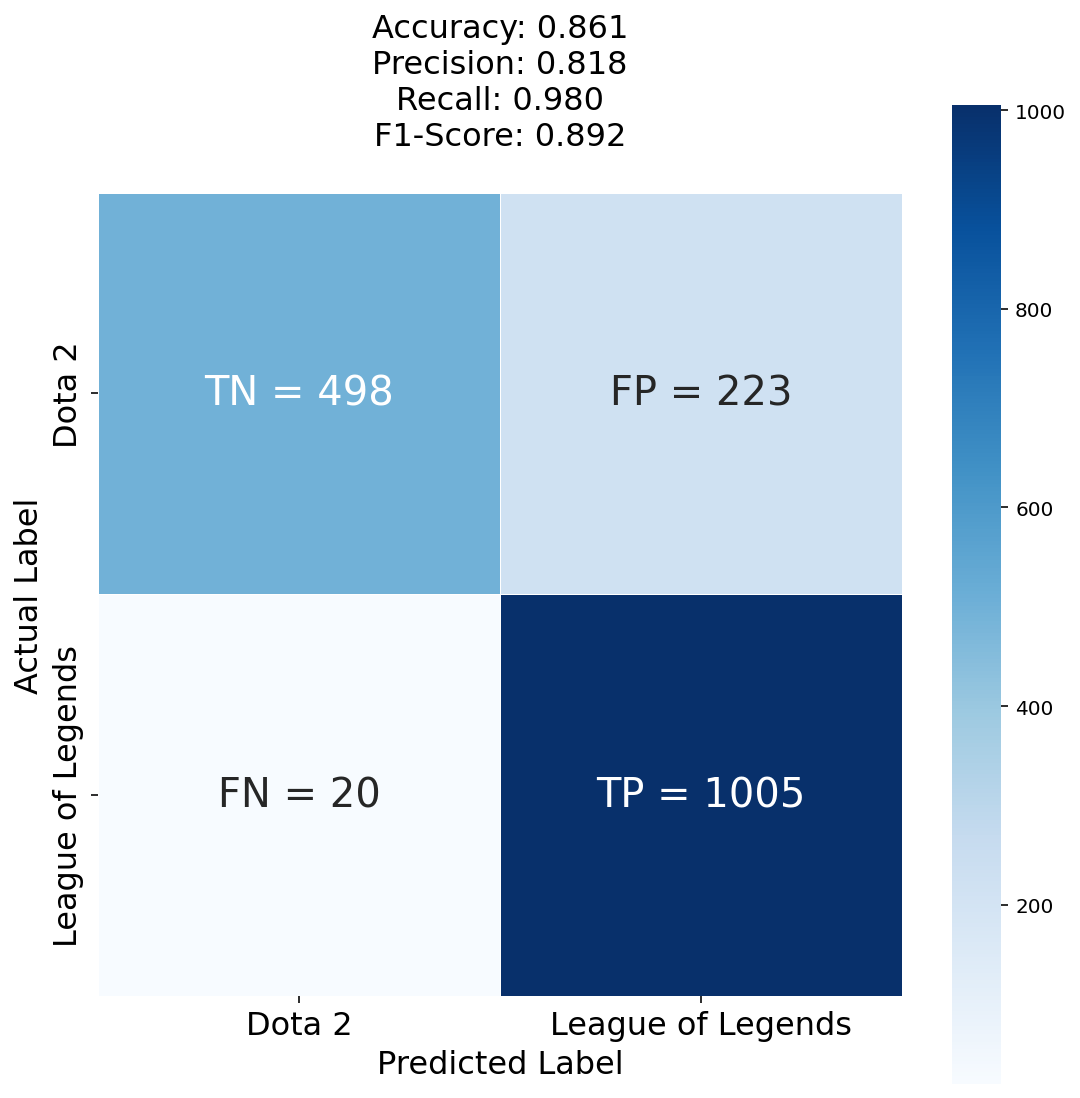

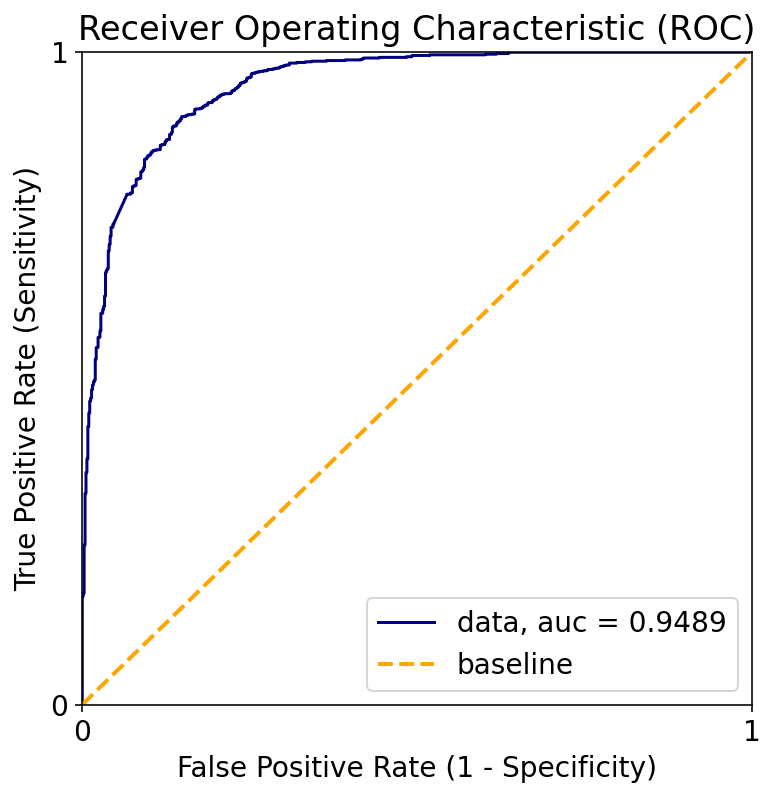

--- Executed in 0:00:02 HH:mm:ss ---


In [40]:
start_time = time.time()

pipe_cvec_lr = Pipeline([('cvec', CountVectorizer()), ('lr', LogisticRegression())])

# Define Pipe Parameters                                     (Refer to comments below for original parameters)
pp_cvec_lr = {'cvec__max_features': [4_000],                                  # [4_000]
              'cvec__min_df': [2],                                            # [2]
              'cvec__max_df': [.85],                                          # [.85, .9]
              'cvec__ngram_range': [(1, 1)],                                  # [(1, 1), (2, 2)]
              'lr__C': [0.09540954763499938],                                 # np.logspace(-2, 2, 50)
              'lr__solver': ['liblinear'],                                    # ['liblinear']
              'lr__max_iter': [2_000],                                        # [2_000]
              'lr__penalty': ['l1', 'l2'],                                    # ['l1', 'l2']
              'lr__random_state': [123]}                                      # [123]

scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

# GridSearchCV
gs_cvec_lr = GridSearchCV(pipe_cvec_lr, param_grid = pp_cvec_lr, cv = 5, scoring = scoring, refit = 'AUC')

# GridSearchCV Results
gs_cvec_lr.fit(X_train, y_train)
score_dict_cvec_lr = {}
score_dict_cvec_lr = model_perform(gs_cvec_lr, X_train, y_train, X_test, y_test)
score_dict_cvec_lr['model'] = 'CountVec + Logistic Regression'
scores_cvec_lr = []
scores_cvec_lr.append(score_dict_cvec_lr)

print('--- Executed in %s HH:mm:ss ---' % str(datetime.timedelta(seconds = round((time.time() - start_time), 0))))

(<AxesSubplot:title={'center':'Dota 2'}, xlabel='Importance', ylabel='Words'>,
 <AxesSubplot:title={'center':'League of Legends'}, xlabel='Importance', ylabel='Words'>)

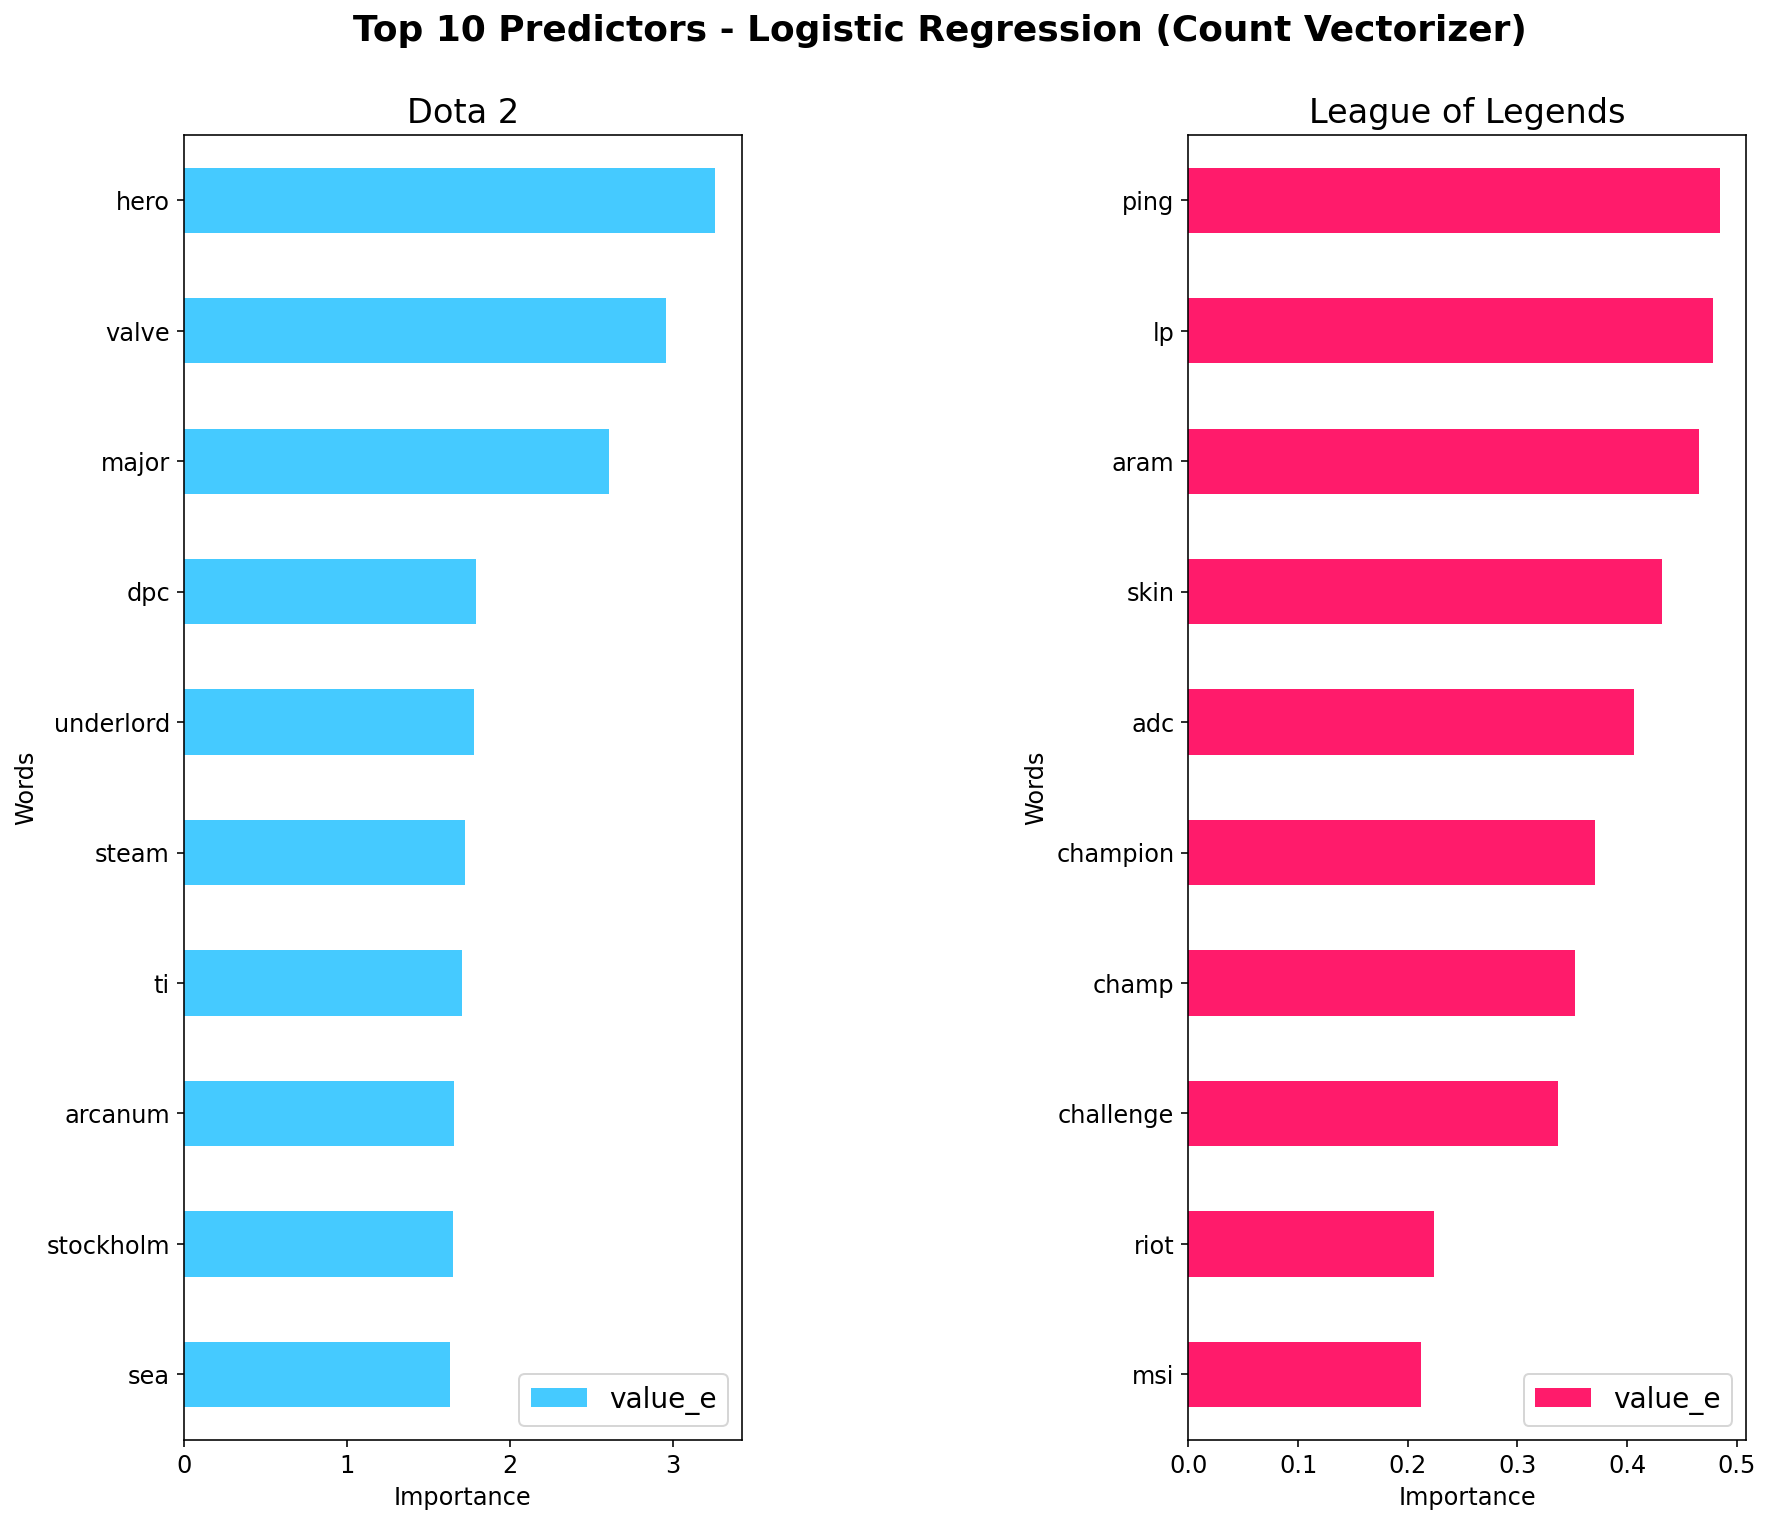

In [41]:
# Display Top 10 Predictors
dota_coef, lol_coef = features(gs_cvec_lr.best_estimator_.named_steps.cvec, 
                               gs_cvec_lr.best_estimator_.named_steps.lr, 10)
barsubplots_feat(lol_coef, dota_coef, 
            title = 'Top 10 Predictors - Logistic Regression (Count Vectorizer)', xlabel = 'Importance')

**Interpretation:**
- For the purpose of interpreting the model, we exponentiate the y-coefficients of the logarithmic function for both subreddits.
  - If the word **hero** appears in a post, we are 3 times more likely to classify the post as Dota 2's.
  - If the word **ping** appears in a post, we are ¬Ω times more likely to classify the post as Dota 2's i.e. 2 times more likely to classify the post as LoL's.
- Many of the top 25 most frequent words (1 ngram) also appear here for both subreddits, reinforcing our confidence that the logistic regression model would potentially classify each post with considerably high accuracy, e.g.
  - **Dota 2**: hero, valve, major, underlord, steam, stockholm
  - **LoL**: lp, skin, adc, champion, champ, challenge, riot, msi

### Logistic Regression (TF-IDF Vectorizer)

Optimal Grid Search Model Parameters: 
{'lr__C': 1.0985411419875584, 'lr__max_iter': 20000, 'lr__penalty': 'l2', 'lr__random_state': 123, 'lr__solver': 'liblinear', 'tvec__max_features': 4000, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': 'english'}

Optimal Grid Search Best Score: 
0.9587857447477537

Train AUC Score: 
0.9945985598978482

Test AUC SCore: 
0.9587226413179527

Train Accuracy Score: 
0.9425343811394892

Test Accuracy Score: 
0.8820160366552119

Precision: 
0.8551604509973981

Recall or Sensitivity: 
0.9619512195121951

Specificity: 
0.768377253814147

F1-Score: 
0.9054178145087235



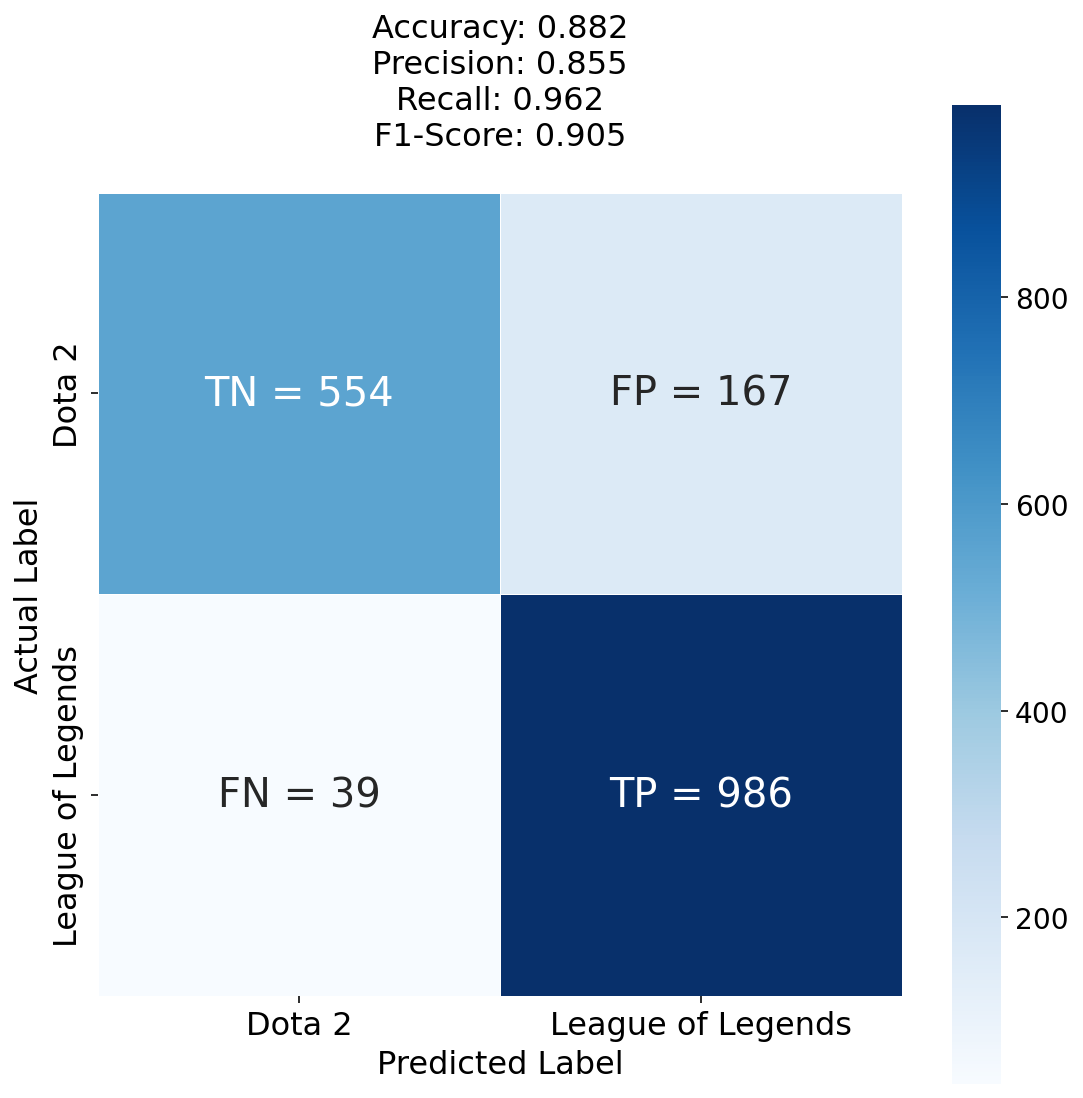

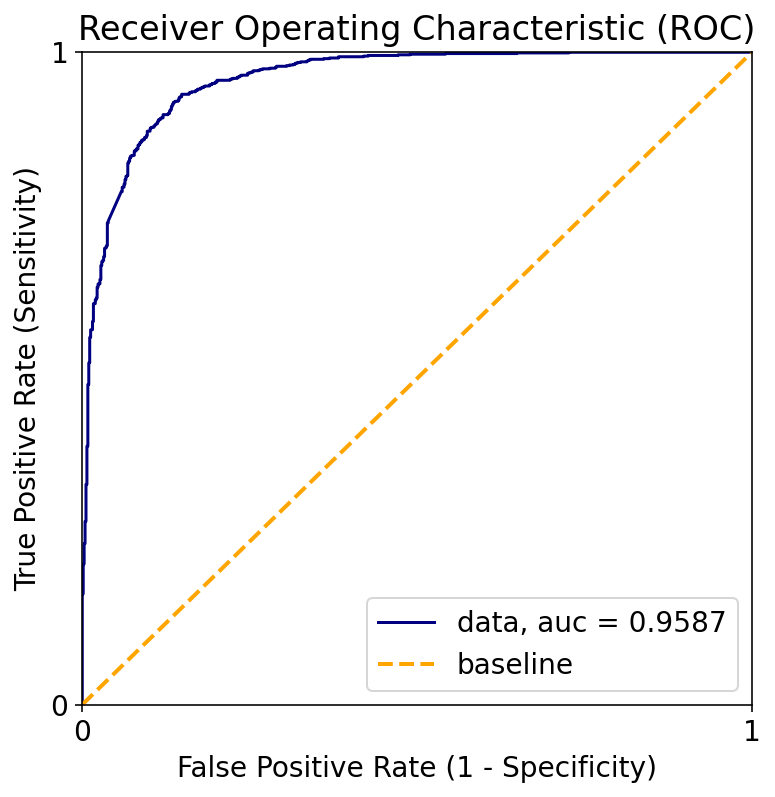

--- Executed in 0:00:02 HH:mm:ss ---


In [42]:
start_time = time.time()

pipe_tvec_lr = Pipeline([('tvec', TfidfVectorizer()), ('lr', LogisticRegression())])

# Define Pipe Parameters                                       (Refer to comments for original parameters)
pp_tvec_lr = {'tvec__max_features': [4_000],                                # [3_000, 4_000]
              'tvec__stop_words': ['english'],                              # ['english']
              'tvec__ngram_range': [(1, 1)],                                # [(1, 1), (2, 2)]
              'lr__C': [1.0985411419875584],                                # np.logspace(-2, 2, 50)
              'lr__solver': ['liblinear'],                                  # ['liblinear']
              'lr__max_iter': [20_000],                                     # [20_000]
              'lr__penalty': ['l1', 'l2'],                                  # ['l1', 'l2']
              'lr__random_state': [123]}                                    # [123]

scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

# GridSearchCV
gs_tvec_lr = GridSearchCV(pipe_tvec_lr, param_grid = pp_tvec_lr, cv = 5, scoring = scoring, refit = 'AUC')

# GridSearchCV Results
gs_tvec_lr.fit(X_train, y_train)
score_dict_tvec_lr = {}
score_dict_tvec_lr = model_perform(gs_tvec_lr, X_train, y_train, X_test, y_test)
score_dict_tvec_lr['model'] = 'TF-IDFVec + Logistic Regression'
scores_tvec_lr = []
scores_tvec_lr.append(score_dict_tvec_lr)

print('--- Executed in %s HH:mm:ss ---' % str(datetime.timedelta(seconds = round((time.time() - start_time), 0))))

(<AxesSubplot:title={'center':'Dota 2'}, xlabel='Importance', ylabel='Words'>,
 <AxesSubplot:title={'center':'League of Legends'}, xlabel='Importance', ylabel='Words'>)

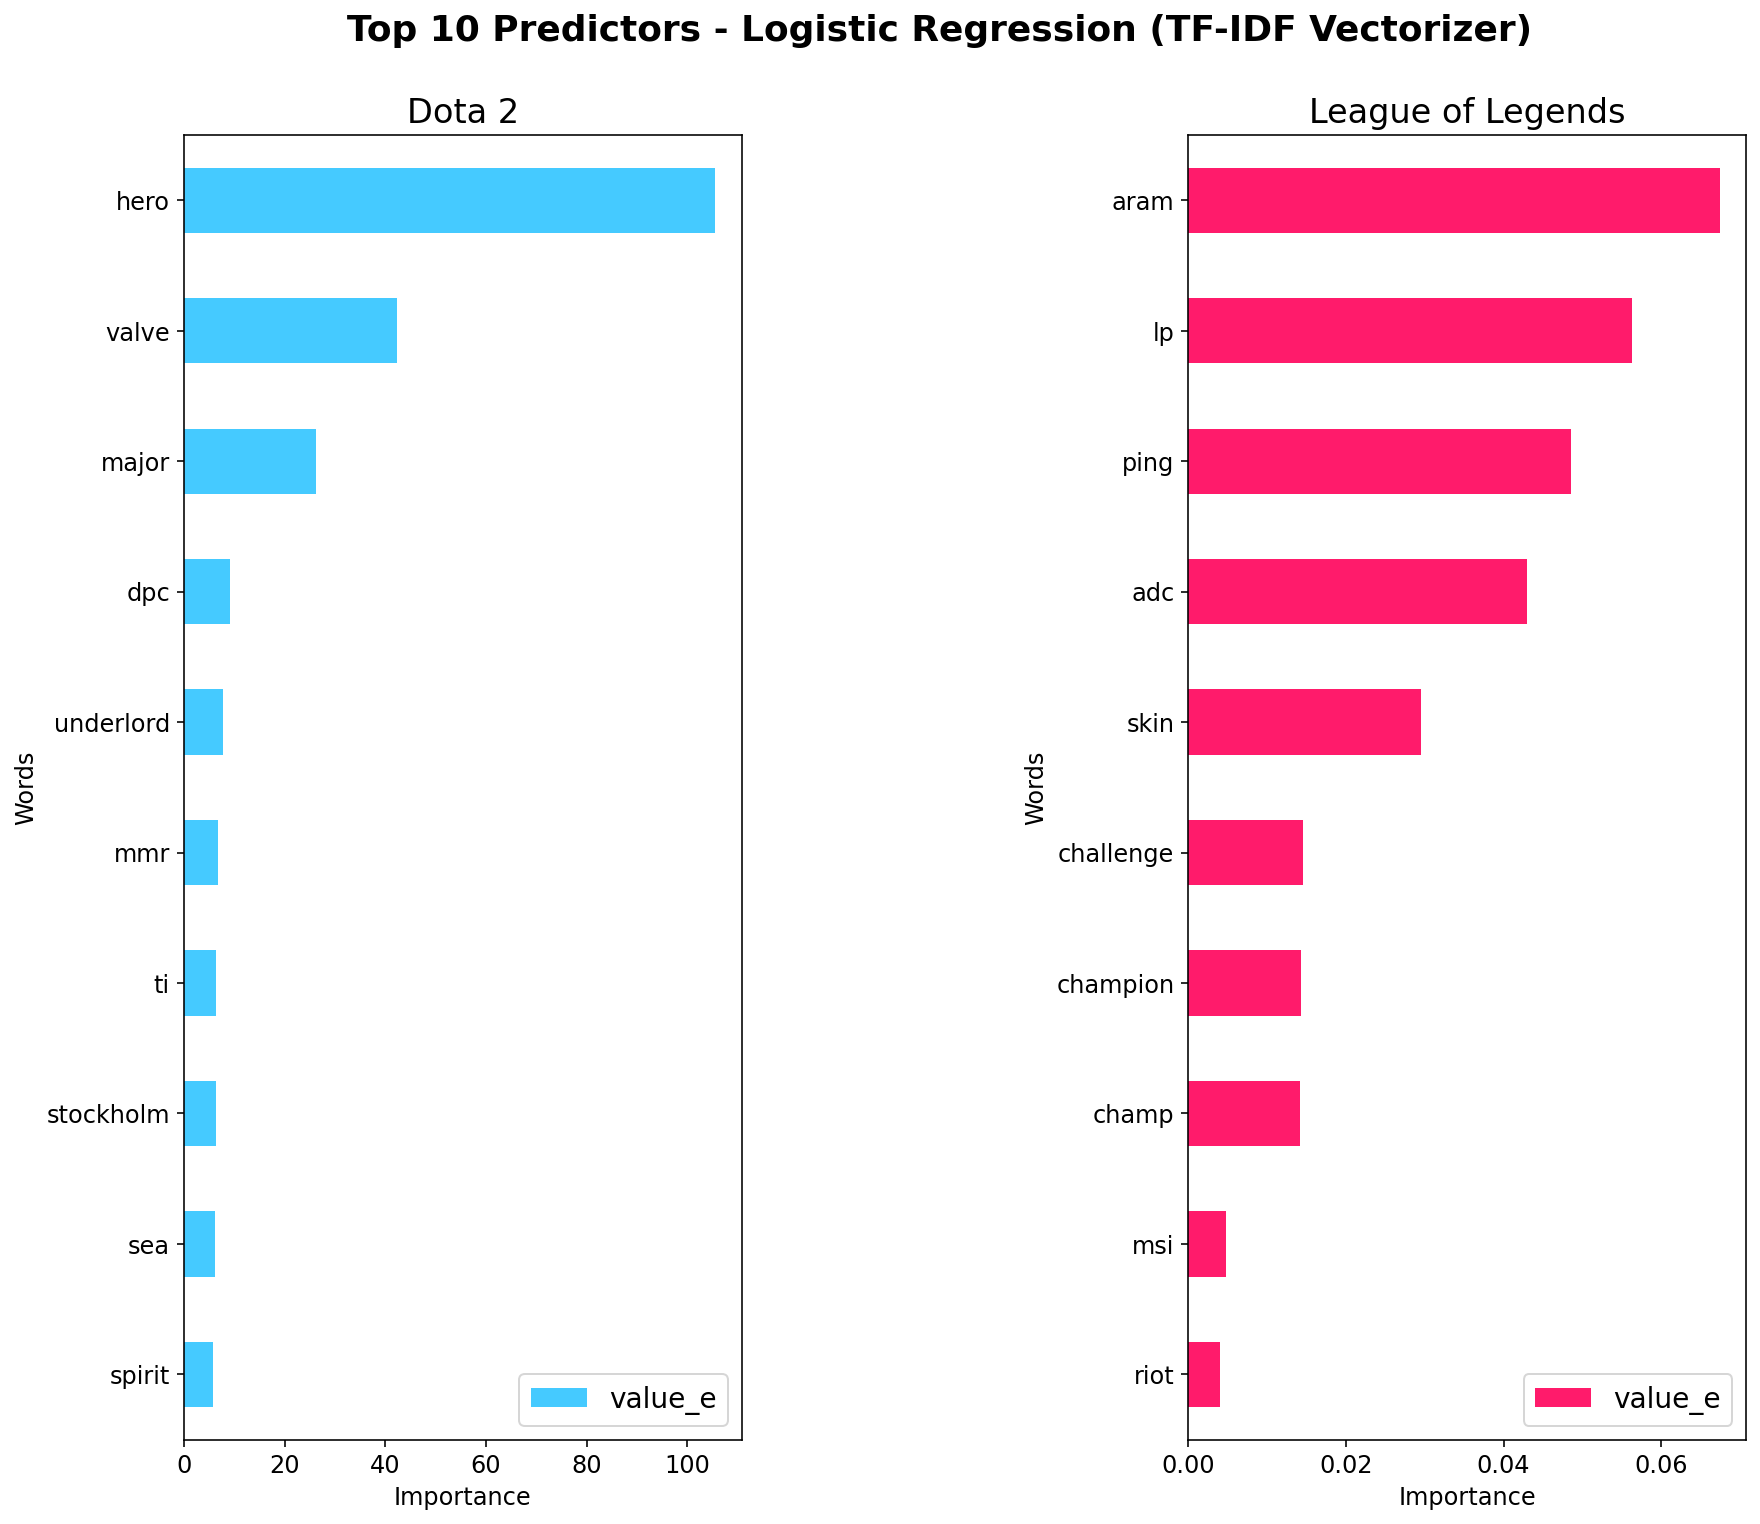

In [43]:
# Display Top 10 Predictors
dota_coef, lol_coef = features(gs_tvec_lr.best_estimator_.named_steps.tvec, 
                               gs_tvec_lr.best_estimator_.named_steps.lr, 10)
barsubplots_feat(lol_coef, dota_coef, 
            title = 'Top 10 Predictors - Logistic Regression (TF-IDF Vectorizer)', xlabel = 'Importance')

**Interpretation:**
- Similar to the logistic regression using count vectorizer, for the purpose of interpreting the model, we exponentiate the y-coefficients of the logarithmic function for both subreddits.
  - If the word **hero** appears in a post, we are 100 times more likely to classify the post as Dota 2's.
  - If the word **aram** appears in a post, we are 1/0.07 times more likely to classify the post as Dota 2's i.e. ~14 times more likely to classify the post as LoL's.
- Since most of these top 10 predictors are also found amongst the top 25 most frequent words (1 ngram) for the corresponding subreddits, this boosts our confidence that the logistic regression model would potentially classify each post with considerably high accuracy, e.g.
  - **Dota 2**: hero, valve, major, dpc, underlord, mmr, ti, stockholm, sea, spirit
  - **LoL**: aram, lp, ping, skin, adc, champion, champ, challenge, riot, msi

### Multinomial Naive Bayes (Count Vectorizer)

Optimal Grid Search Model Parameters: 
{'cvec__max_df': 0.8, 'cvec__max_features': 4000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 1)}

Optimal Grid Search Best Score: 
0.9629922798483989

Train AUC Score: 
0.9847282317673571

Test AUC SCore: 
0.9622333479922871

Train Accuracy Score: 
0.9386051080550099

Test Accuracy Score: 
0.8917525773195877

Precision: 
0.9171656686626747

Recall or Sensitivity: 
0.8965853658536586

Specificity: 
0.8848821081830791

F1-Score: 
0.9067587567834238



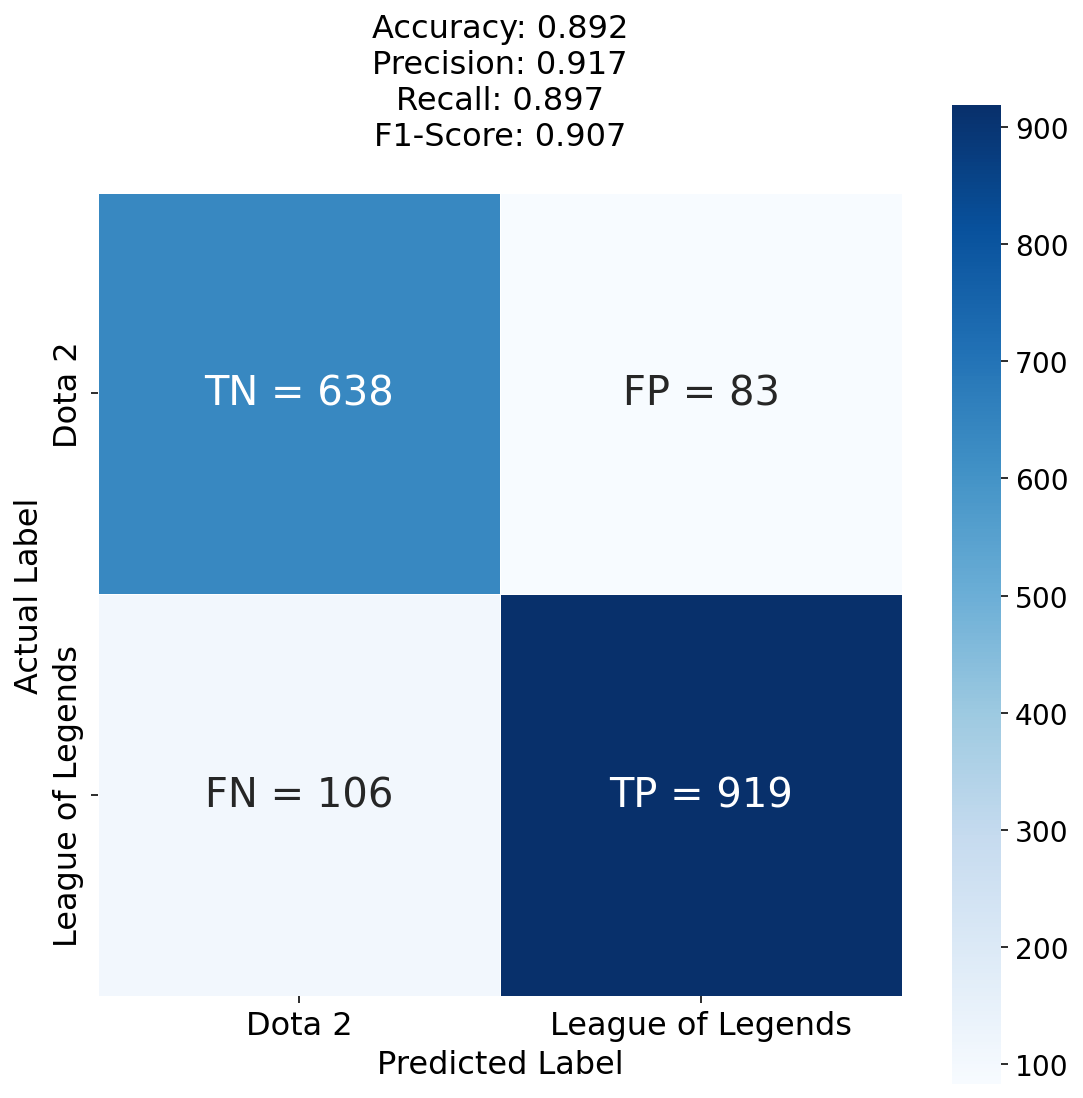

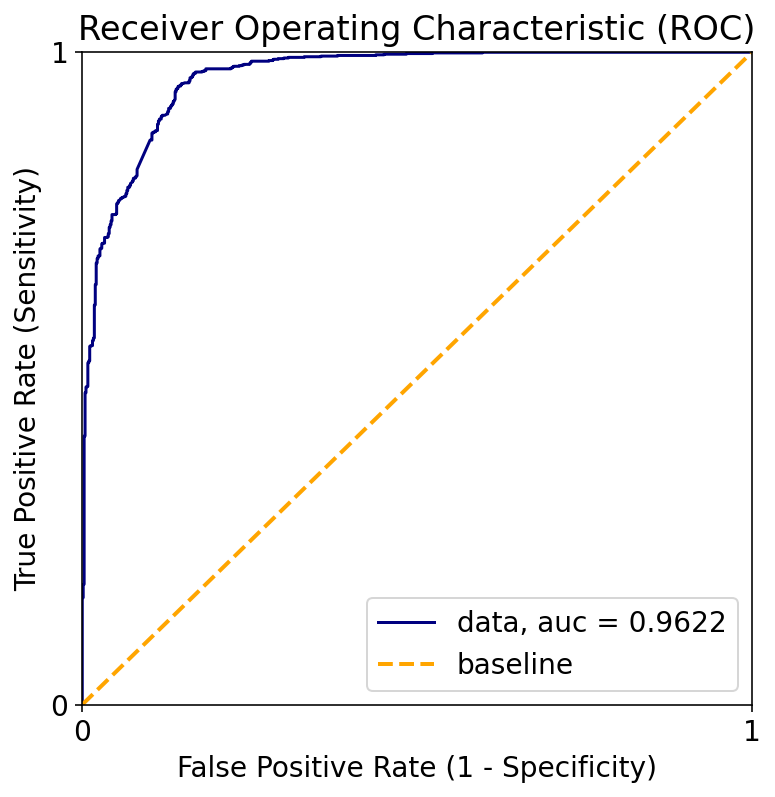

--- Executed in 0:00:31 HH:mm:ss ---


In [44]:
start_time = time.time()

pipe_cvec_nb = Pipeline([('cvec', CountVectorizer()), ('nb', MultinomialNB())])

# Define Pipe Parameters
pp_cvec_nb = {'cvec__max_features': [2_000, 3_000, 4_000], 
              'cvec__min_df': [2, 3], 
              'cvec__max_df': [0.8, 0.85, 0.9], 
              'cvec__ngram_range': [(1, 1), (1, 2)]}

scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

# GridSearchCV
gs_cvec_nb = GridSearchCV(pipe_cvec_nb, param_grid = pp_cvec_nb, cv = 5, scoring = scoring, refit = 'AUC')

# GridSearchCV Results
gs_cvec_nb.fit(X_train, y_train)
score_dict_cvec_nb = {}
score_dict_cvec_nb = model_perform(gs_cvec_nb, X_train, y_train, X_test, y_test)
score_dict_cvec_nb['model'] = 'CountVec + Multinomial Naive Bayes'
scores_cvec_nb = []
scores_cvec_nb.append(score_dict_cvec_nb)

print('--- Executed in %s HH:mm:ss ---' % str(datetime.timedelta(seconds = round((time.time() - start_time), 0))))

In [45]:
# Function to get most important words based on log probability of features of the Multinomial Naive Bayes model
def features_nb(vectoriser, estimator, ascending = True):
    
    delta_log_prob = estimator.feature_log_prob_[1, :] - estimator.feature_log_prob_[0, :]
    feature_names = vectoriser.get_feature_names_out()    
    
    df = pd.DataFrame({'feature': feature_names, 'difference_log_prob': delta_log_prob})
    df.sort_values(by = ['difference_log_prob'], ascending = ascending, inplace = True)
        
    return df

In [46]:
# Display Top 10 Predictors for Dota 2
features_nb(gs_cvec_nb.best_estimator_.named_steps.cvec, 
            gs_cvec_nb.best_estimator_.named_steps.nb, ascending = False)[:10]

feature  difference_log_prob
382         bo2                 6.22
1524     gt00lt                 5.40
3306  stockholm                 5.04
1009        dpc                 4.93
1152        esl                 4.78
1817       john                 4.77
3522    thunder                 4.68
348     betboom                 4.60
1981     liquid                 4.60
1416     gaimin                 4.54

In [47]:
# Display Top 10 Predictors for League of Legends
features_nb(gs_cvec_nb.best_estimator_.named_steps.cvec, 
            gs_cvec_nb.best_estimator_.named_steps.nb, ascending = True)[:10]

feature  difference_log_prob
3734      urf                -4.96
2068   maokai                -4.87
44        adc                -4.77
552     champ                -4.76
1887   lagfix                -4.57
1862     kled                -4.41
1197  exhaust                -4.41
3993    ziggs                -4.30
1411       g2                -4.30
192      aram                -4.25

**Interpretation:**
- Since Dota 2 and LoL were initially assigned 1 and 0 respectively, in the presence of **bo2** in a post, which has the highest difference of feature log probability, the model will more likely predict the post to belong to Dota 2. Similary, in the presence of **urf** in a post, the model will more likely predict the post to belong to League of Legends (LoL).
- As at least 4 of these top 10 predictors for each subreddit are also found amongst the top 25 most frequent words (1 ngram) for the Dota 2 subreddit, this boosts our confidence that the logistic regression model would potentially classify each post with considerably high accuracy too, e.g.
  - **Dota 2**: bo2, gt00lt, stockholm, dpc, esl, thunder
  - **LoL**: urf, maokai, adc, champ

### Multinomial Naive Bayes (TF-IDF Vectorizer)

Optimal Grid Search Model Parameters: 
{'tvec__max_features': 5000, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': 'english'}

Optimal Grid Search Best Score: 
0.9649836856299011

Train AUC Score: 
0.9934967581410838

Test AUC SCore: 
0.963496498765265

Train Accuracy Score: 
0.9607072691552063

Test Accuracy Score: 
0.9020618556701031

Precision: 
0.8968401486988847

Recall or Sensitivity: 
0.9414634146341463

Specificity: 
0.8460471567267683

F1-Score: 
0.9186101856258924



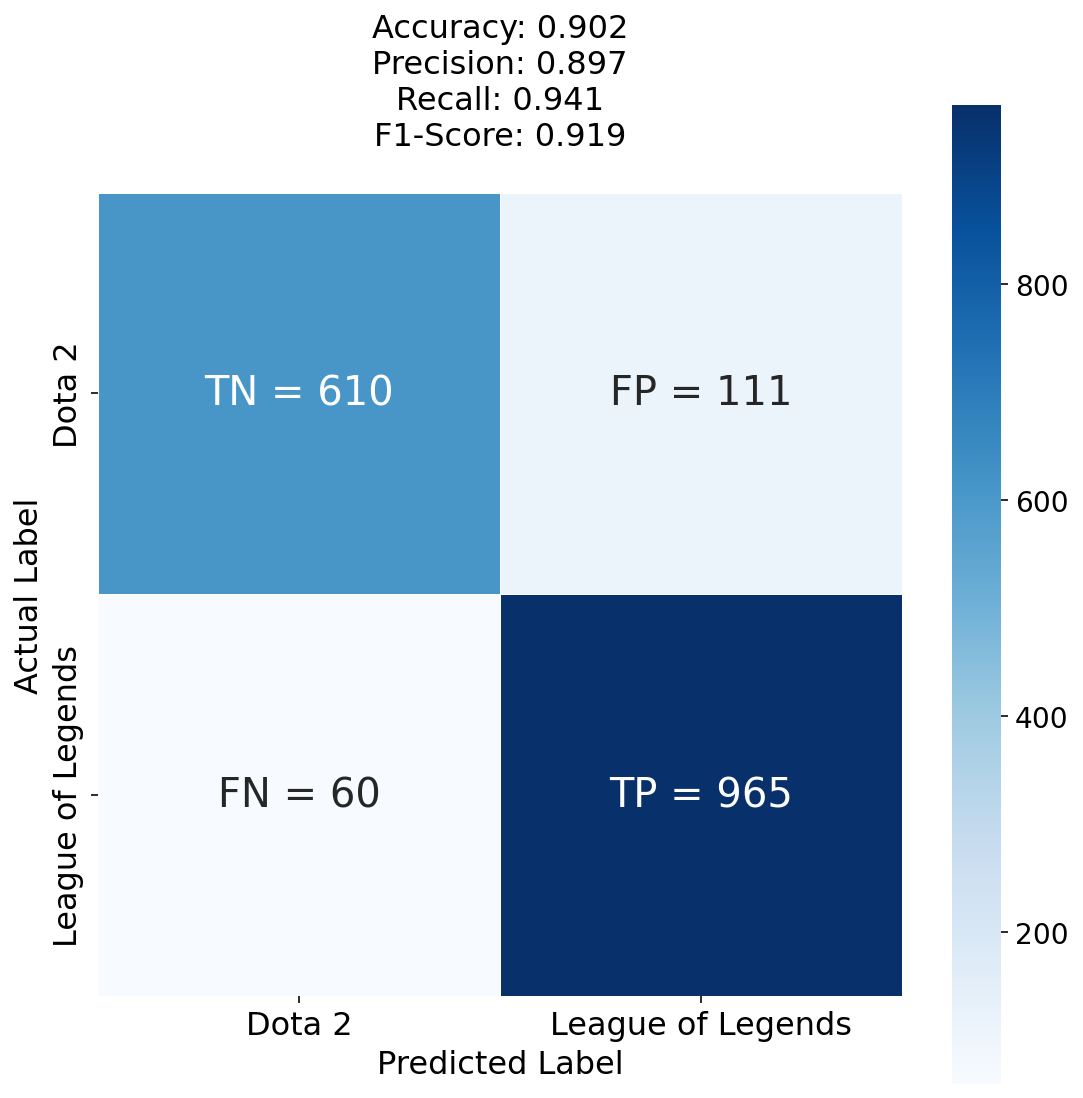

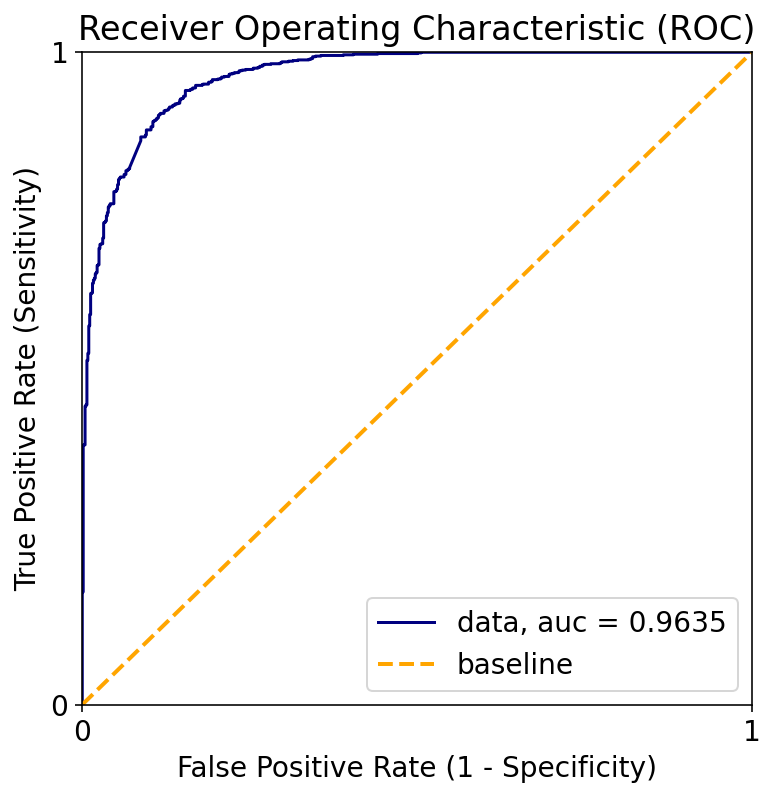

--- Executed in 0:00:11 HH:mm:ss ---


In [48]:
start_time = time.time()

pipe_tvec_nb = Pipeline([('tvec', TfidfVectorizer()), ('nb', MultinomialNB())])

# Define Pipe Parameters
pp_tvec_nb = {'tvec__max_features': [3_000, 4_000, 5_000], 
               'tvec__stop_words': [None, 'english'], 
               'tvec__ngram_range': [(1, 1), (1, 2)]}

scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

# GridSearchCV
gs_tvec_nb = GridSearchCV(pipe_tvec_nb, param_grid = pp_tvec_nb, cv = 5, scoring = scoring, refit = 'AUC')

# GridSearchCV Results
gs_tvec_nb.fit(X_train, y_train)
score_dict_tvec_nb = {}
score_dict_tvec_nb = model_perform(gs_tvec_nb, X_train, y_train, X_test, y_test)
score_dict_tvec_nb['model'] = 'TF-IDFVec + Logistic Regression'
scores_tvec_nb = []
scores_tvec_nb.append(score_dict_tvec_nb)

print('--- Executed in %s HH:mm:ss ---' % str(datetime.timedelta(seconds = round((time.time() - start_time), 0))))

In [49]:
# Display Top 10 Predictors for Dota 2
features_nb(gs_tvec_nb.best_estimator_.named_steps.tvec, 
            gs_tvec_nb.best_estimator_.named_steps.nb, ascending = False)[:10]

feature  difference_log_prob
1959       hero                 3.34
4700      valve                 3.28
4148  stockholm                 3.25
4609  underlord                 3.08
1254        dpc                 2.97
1410        esl                 2.81
3206         po                 2.61
4395         ti                 2.57
3444    rampage                 2.54
2593      major                 2.54

In [50]:
# Display Top 10 Predictors for League of Legends
features_nb(gs_tvec_nb.best_estimator_.named_steps.tvec, 
            gs_tvec_nb.best_estimator_.named_steps.nb, ascending = True)[:10]

feature  difference_log_prob
716      champ                -3.34
2813       msi                -3.30
3671      riot                -3.24
62         adc                -3.01
4664       urf                -2.79
4434     token                -2.77
1718        g2                -2.74
237       aram                -2.73
717   champion                -2.71
3682       rng                -2.57

**Interpretation:**
- Since Dota 2 and LoL were initially assigned 1 and 0 respectively, in the presence of **hero** in a post, which has the highest difference of feature log probability, the model will more likely predict the post to belong to Dota 2. Similary, in the presence of **champ** in a post, the model will more likely predict the post to belong to League of Legends (LoL).
- As **ALL** of these top 10 predictors for each subreddit are also found amongst the top 25 most frequent words (1 ngram) for the Dota 2 subreddit, this boosts our confidence that the logistic regression model would potentially classify each post with considerably high accuracy too, e.g.
  - **Dota 2**: hero, valve, stockholm, underlord, dpc, esl, po, ti, rampage, major
  - **LoL**: hero, valve, stockholm, underlord, dpc, esl, po, ti, rampage, major

### Random Forest Classifier (Count Vectorizer)

Optimal Grid Search Model Parameters: 
{'cvec__max_df': 0.8, 'cvec__max_features': 4000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1)}

Optimal Grid Search Best Score: 
0.9325347801118566

Train AUC Score: 
0.9981710836978855

Test AUC SCore: 
0.9364182537803186

Train Accuracy Score: 
0.9948428290766208

Test Accuracy Score: 
0.8711340206185567

Precision: 
0.8824091778202677

Recall or Sensitivity: 
0.9004878048780488

Specificity: 
0.8294036061026352

F1-Score: 
0.8913568324480927



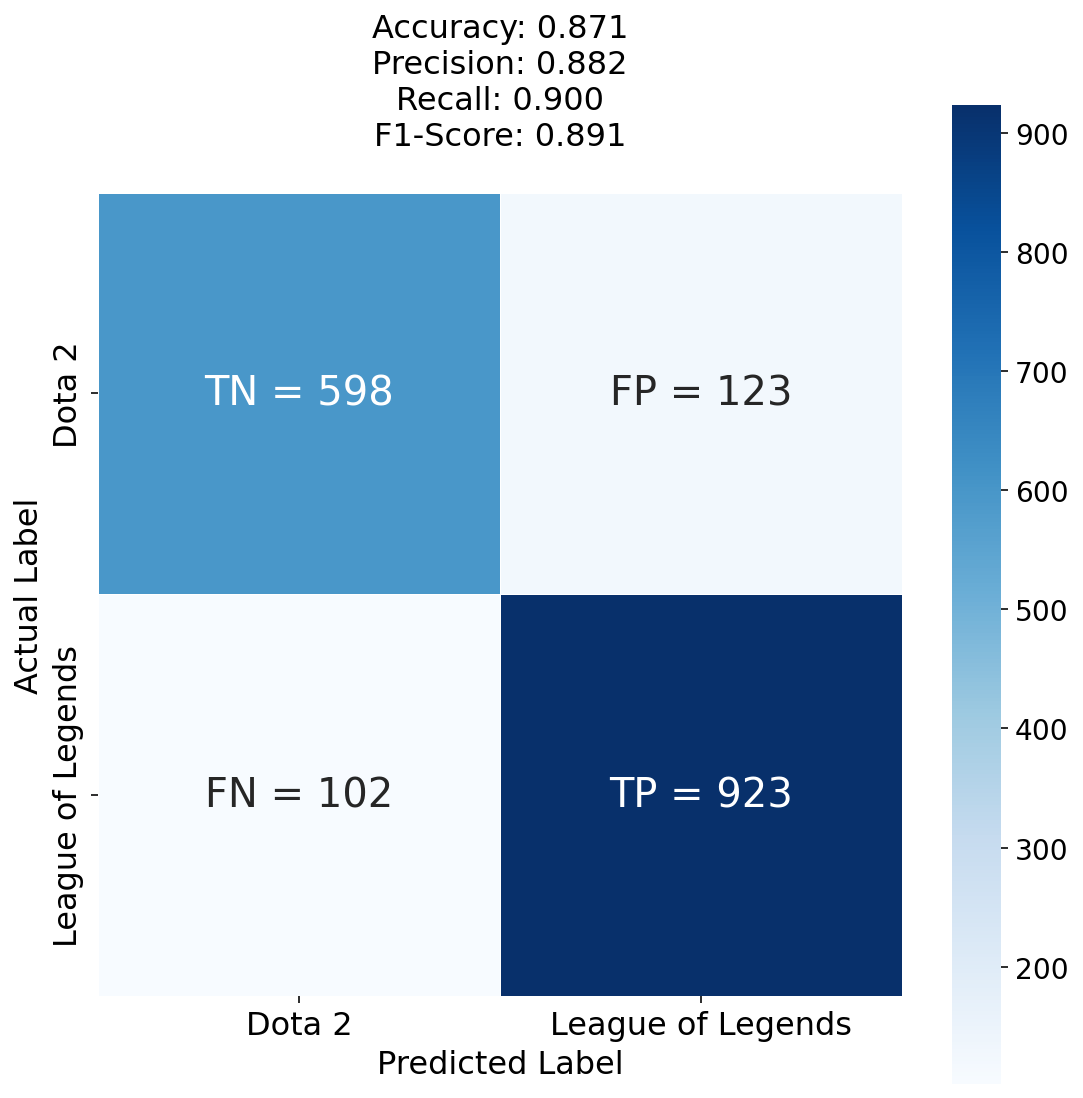

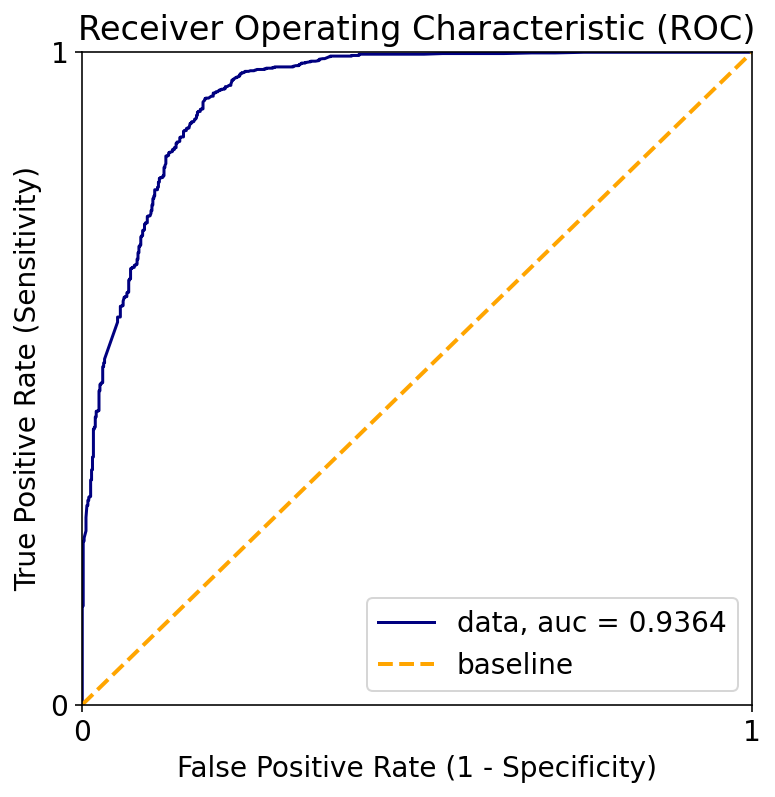

--- Executed in 0:03:03 HH:mm:ss ---


In [51]:
start_time = time.time()

pipe_cvec_rf = Pipeline([('cvec', CountVectorizer()), ('rf', RandomForestClassifier())])

# Define Pipe Parameters
pp_cvec_rf = {'cvec__max_features': [2_000, 3_000, 4_000], 
              'cvec__min_df': [2, 3], 
              'cvec__max_df': [0.8, 0.85, 0.9], 
              'cvec__ngram_range': [(1, 1), (2, 2)]}

scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

# GridSearchCV
gs_cvec_rf = GridSearchCV(pipe_cvec_rf, param_grid = pp_cvec_rf, cv = 5, scoring = scoring, refit = 'AUC')

# GridSearchCV Results
gs_cvec_rf.fit(X_train, y_train)
score_dict_cvec_rf = {}
score_dict_cvec_rf = model_perform(gs_cvec_rf, X_train, y_train, X_test, y_test)
score_dict_cvec_rf['model'] = 'CountVec + Random Forest'
scores_cvec_rf = []
scores_cvec_rf.append(score_dict_cvec_rf)

print('--- Executed in %s HH:mm:ss ---' % str(datetime.timedelta(seconds = round((time.time() - start_time), 0))))

In [52]:
# Function to get most important words based on impurity-based feature importances of the Random Forest model
# The higher, the more important the feature. 
# The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. 
# It is also known as the Gini importance.
features_dict = {}
importance = gs_cvec_rf.best_estimator_.named_steps.rf.feature_importances_
# summarize feature importance
for index, value in enumerate(importance):
    features_dict[index] = value

features_list = sorted(features_dict, key = features_dict.get, reverse = True)

print(f'The index for the 10 most important features in decreasing order are: \n{features_list[:10]}')

The index for the 10 most important features in decreasing order are: 
[2925, 2218, 564, 561, 565, 1596, 45, 3184, 188, 3767]


### Random Forest Classifier (TF-IDF Vectorizer)

Optimal Grid Search Model Parameters: 
{'rf__max_depth': None, 'rf__n_estimators': 200, 'rf__random_state': 123, 'tvec__max_features': 5000, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': 'english'}

Optimal Grid Search Best Score: 
0.9366003433611663

Train AUC Score: 
0.9989711957185428

Test AUC SCore: 
0.943955887825175

Train Accuracy Score: 
0.9948428290766208

Test Accuracy Score: 
0.8911798396334479

Precision: 
0.8659070990359334

Recall or Sensitivity: 
0.9639024390243902

Specificity: 
0.7877947295423023

F1-Score: 
0.912280701754386



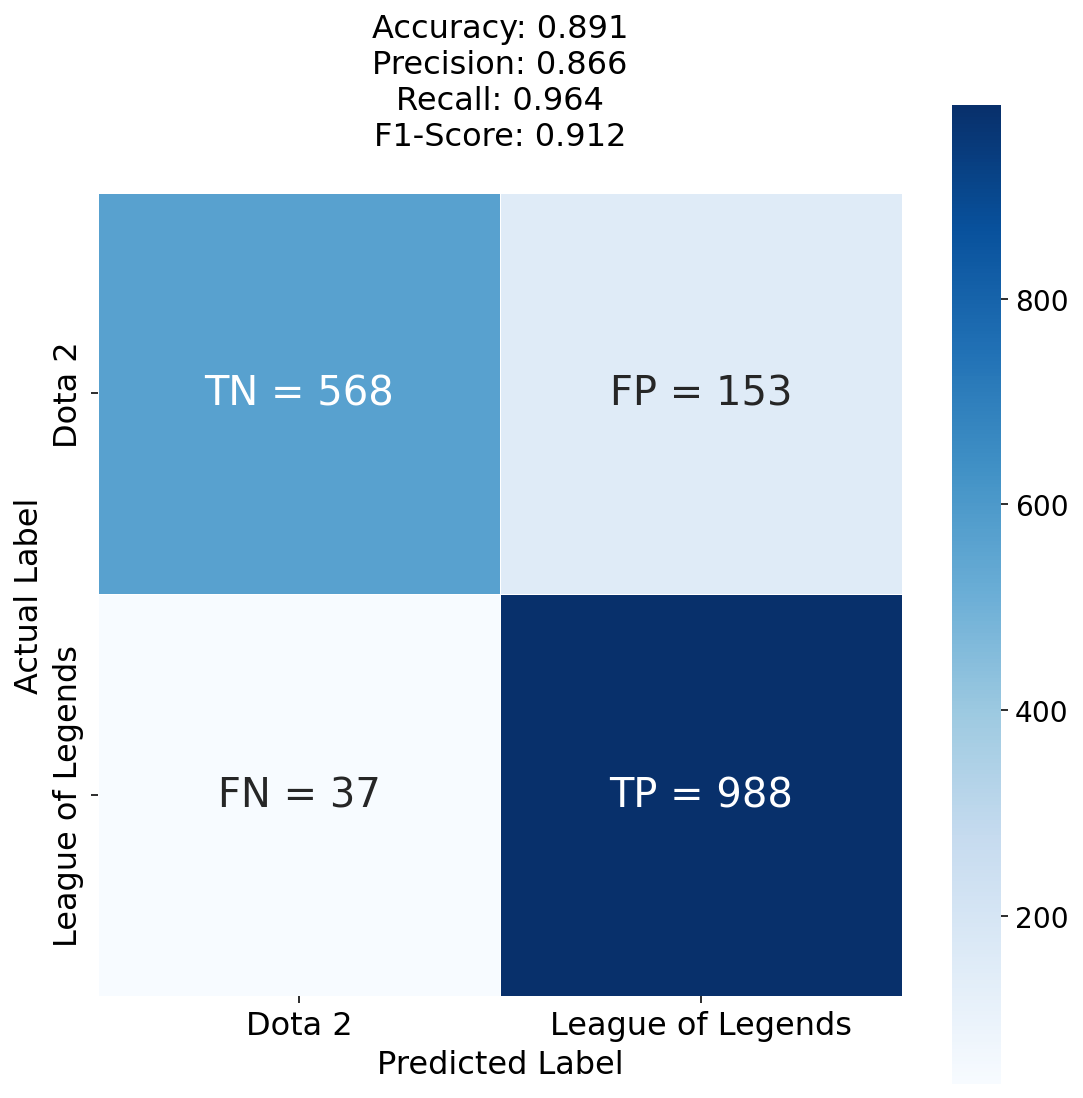

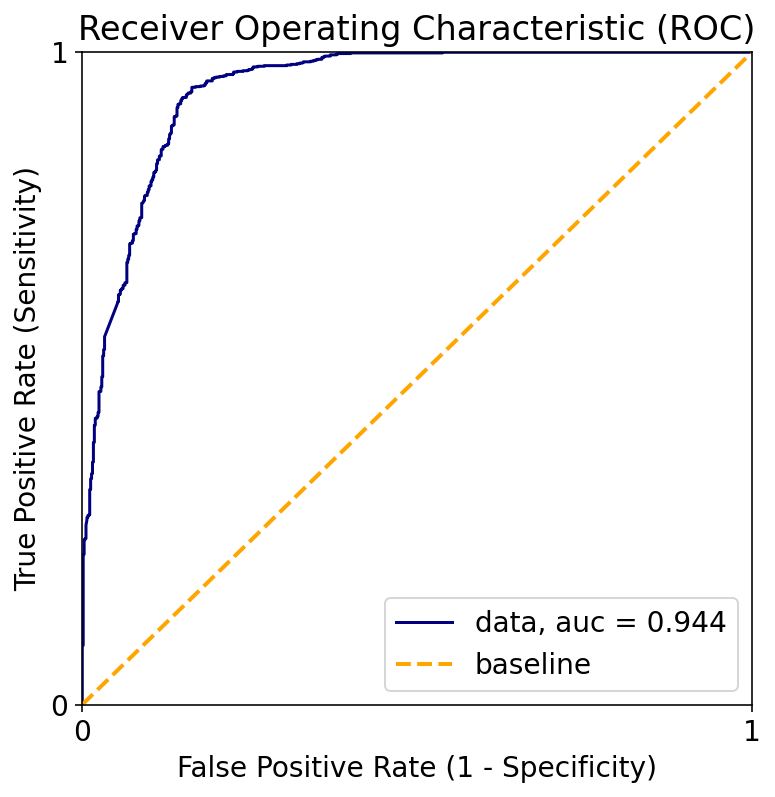

--- Executed in 0:02:07 HH:mm:ss ---


In [53]:
start_time = time.time()

pipe_tvec_rf = Pipeline([('tvec', TfidfVectorizer()), ('rf', RandomForestClassifier())])

# Define Pipe Parameters
pp_tvec_rf = {'tvec__max_features': [4_000, 5_000], 
              'tvec__stop_words': ['english'], 
              'tvec__ngram_range': [(1, 1), (2, 2)], 
              'rf__n_estimators': [100, 150, 200], 
              'rf__max_depth': [None, 4], 
              'rf__random_state': [123]}

scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

# GridSearchCV
gs_tvec_rf = GridSearchCV(pipe_tvec_rf, param_grid = pp_tvec_rf, cv = 5, scoring = scoring, refit = 'AUC')

# GridSearchCV Results
gs_tvec_rf.fit(X_train, y_train)
score_dict_tvec_rf = {}
score_dict_tvec_rf = model_perform(gs_tvec_rf, X_train, y_train, X_test, y_test)
score_dict_tvec_rf['model'] = 'TF-IDFVec + Random Forest'
scores_tvec_rf = []
scores_tvec_rf.append(score_dict_tvec_rf)

print('--- Executed in %s HH:mm:ss ---' % str(datetime.timedelta(seconds = round((time.time() - start_time), 0))))

In [55]:
# Function to get most important words based on impurity-based feature importances of the Random Forest model
# The higher, the more important the feature. 
# The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. 
# It is also known as the Gini importance.
features_dict = {}
importance = gs_tvec_rf.best_estimator_.named_steps.rf.feature_importances_
# summarize feature importance
for index, value in enumerate(importance):
    features_dict[index] = value

features_list = sorted(features_dict, key = features_dict.get, reverse = True)

print(f'The index for the 10 most important features in decreasing order are: \n{features_list[:10]}')

The index for the 10 most important features in decreasing order are: 
[3671, 2813, 717, 716, 713, 1959, 3964, 62, 3167, 4700]


### Summary Table of Model Performance

| **Model**              | **Logistic<br>Regression** | **Logistic<br>Regression** | **Multinomial<br>Naive Bayes** | **Multinomial<br>Naive Bayes** | **Random Forest<br>Classifier** | **Random Forest<br>Classifier** |
|------------------------|----------------------------|----------------------------|--------------------------------|--------------------------------|---------------------------------|---------------------------------|
| **Vectorizer**         | **Count**                  | **TF-IDF**                 | **Count**                      | **TF-IDF**                     | **Count**                       | **TF-IDF**                      |
| Grid Search Best Score | 0.949473161                | 0.958785745                | 0.962992280                     | 0.964983686                    | 0.932471005                     | 0.936600343                     |
| Train AUC Score        | 0.989201224                | 0.994598560                 | 0.984728232                    | 0.993496758                    | 0.998315089                     | 0.998971196                     |
| Test AUC Score         | 0.948869118                | 0.958722641                | 0.962233348                    | 0.963496499                    | 0.936894557                     | 0.943955888                     |
| Train Accuracy Score   | 0.904715128                | 0.942534381                | 0.938605108                    | 0.960707269                    | 0.994842829                     | 0.994842829                     |
| **Test Accuracy Score**    | 0.860824742                | 0.882016037                | 0.891752577                    | **0.902061856**                | 0.875715922                     | 0.891179840                      |
| Precision              | 0.818403909                | 0.855160451                | 0.917165669                    | 0.896840149                    | 0.885496183                     | 0.865907099                     |
| Recall or Sensitivity  | 0.980487805                | 0.961951220                 | 0.896585366                    | 0.941463415                    | 0.905365854                     | 0.963902439                     |
| Specificity            | 0.690707351                | 0.768377254                | 0.884882108                    | 0.846047157                    | 0.833564494                     | 0.787794730                      |
| F1-Score               | 0.892143808                | 0.905417815                | 0.906758757                    | 0.918610186                    | 0.895320791                     | 0.912280702                     |
| True Negative (TN)     | 498                        | 554                        | 638                            | 610                            | 601                             | 568                             |
| False Positive (FP)    | 223                        | 167                        | 83                             | 111                            | 120                             | 153                             |
| False Negative (FN)    | 20                         | 39                         | 106                            | 60                             | 97                              | 37                              |
| True Positive (TP)     | 1005                       | 986                        | 919                            | 965                            | 928                             | 988                             |

### Baseline Score for Accuracy: 0.5868

With reference to our earlier discussion on Baseline Score above during data cleaning, we established **0.5868** as the **baseline score** for our best model to beat.

This baseline score was derived by adopting a highly simplistic approach of predicting every post to be a Dota2 post. Since there are **3414** Dota2 posts and **2404** League of Legends posts, corresponding to **58.68%** and **41.32%** of total posts respectively after removing duplicates and moderated/deleted posts, we would have scored **0.5868** (i.e. **58.68%**) in terms of **Accuracy**.


### Multinomial Naive Bayes' (TF-IDF vectorizer) Score for Accuracy: 0.9021
Referencing the summary table of model performance above, **Multinomial Naive Bayes using TF-IDF vectorizer** yields the highest **Test Accuracy Score** of **0.902061856** which decisively beats the Baseline Score of **0.5868**. Additionally, since the Test Accuracy Score is worse than the Train Accuracy Score by merely 0.058645413, there is likely no over-fitting issues.

Thus, Multinomial Naive Bayes' (TF-IDF vectorizer) is chosen as the best model for our dataset.

In [56]:
# Display Top 10 Predictors for Dota 2
features_nb(gs_cvec_nb.best_estimator_.named_steps.cvec, 
            gs_cvec_nb.best_estimator_.named_steps.nb, ascending = False)[:10]

feature  difference_log_prob
382         bo2                 6.22
1524     gt00lt                 5.40
3306  stockholm                 5.04
1009        dpc                 4.93
1152        esl                 4.78
1817       john                 4.77
3522    thunder                 4.68
348     betboom                 4.60
1981     liquid                 4.60
1416     gaimin                 4.54

In [57]:
# Display Top 10 Predictors for League of Legends
features_nb(gs_tvec_nb.best_estimator_.named_steps.tvec, 
            gs_tvec_nb.best_estimator_.named_steps.nb, ascending = True)[:10]

feature  difference_log_prob
716      champ                -3.34
2813       msi                -3.30
3671      riot                -3.24
62         adc                -3.01
4664       urf                -2.79
4434     token                -2.77
1718        g2                -2.74
237       aram                -2.73
717   champion                -2.71
3682       rng                -2.57

**Interpretation:**
- Since Dota 2 and LoL were initially assigned 1 and 0 respectively, in the presence of **bo2** in a post, which has the highest difference of feature log probability, the model will more likely predict the post to belong to Dota 2.
- Similarly, since more than 1/2 of these top 10 predictors are also found amongst the top 25 most frequent words (1 ngram) for the Dota 2 subreddit, this boosts our confidence that the logistic regression model would potentially classify each post with considerably high accuracy too, e.g.
  - **Dota 2**: bo2, gt00lt, stockholm, dpc, esl, thunder

### Limitations and Future Plans

**1) Model Accuracy Improvement**
 - Better data cleaning steps e.g. remove additional Character Entities
 - Further hyperparameter tuning to enhance accuracy, while balancing 
 - Identify and rectify cause(s) for model's post misclassifications (i.e. False Positives and False Negatives)

**2) Include New Model Features**
 - Analyse moderated posts to implement auto regulation of potential user rogue behaviour e.g. profanities, spams, scams, etc.
 - Sentiment analysis

### Recommendations and Conclusion

_**Internal**_
1) Roll out AI model classification to split posts into 2 separate threads
  - Multinomial Naive Bayes' (TF-IDF vectorizer) Model accuracy > 85% and Top 10 Predictors for each subreddit have been identified
  
2) Establish timeline for future model features roll-out, e.g. auto Twitch forum moderation, sentiment analysis, etc.

3) Tease out campaign specific insights e.g. new users acquisition, advertising, etc.

<br>

_**External**_
1) **Developers**:
 - Data Insights as a Service on sentiments, new games &/or features, etc.
 - Explore potential advertising, partnership, sponsorship opportunities, etc.
 
2) **Esports/Events**:
 - Data Insights as a Service on game interests, event/tournament mechanics, etc.
 - Explore potential advertising, partnership, sponsorship opportunities, etc.

3) **Gaming Streamers**:
 - Insights on peak online user activities, etc.

In conclusion, I developed a Multinomial Naive Bayes' (TF-IDF vectorizer) Model with accuracy > 85% and Top 10 Predictors for each subreddit have been identified, thereby meeting the objectives set out by the Problem Statement.

With the blessings from the business development and marketing stakeholders, I shall proceed to implement the items set out above in the limitations, future plans and recommendations sections. I am confident that we could potentially further enhance user experience when the posts are eventually split into 2 distinct threads. I also look forward to partnering all of you in teasing out campaign specific insights to improve both top and bottom lines for the organisation!